In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt
from astropy.constants import G
import astropy.units as u
import seaborn as sns
from tqdm import tqdm
import os

### After producing the star assignment output (from Thinh's technique in the following codes in the notebook), this section is for making plots

In [2]:
ray_sassign = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/stars_assignment.npy', allow_pickle=True).tolist()
apx_sassign = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/stars_assignment.npy', allow_pickle=True).tolist()

In [4]:
ray_tree = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
apx_tree = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
ray_rawtree = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
apx_rawtree = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final.npy', allow_pickle=True).tolist()

In [9]:
def n_halowstars(sassign, rawtree, tree):
    time = []
    n_halowstars_total = []
    n_halowstars_range1 = [] #range 1: Halo Mass < 1e9 
    n_halowstars_range2 = [] #range 2: 1e9 < Halo Mass < 1e10
    n_halowstars_range3 = [] #range 3: Halo Mass > 1e10
    for idx in sassign.keys():
        time.append(tree['0'][idx]['time'])
        n_total = 0 #counter for n_halowstars_total
        n1 = 0 #counter for n_halowstars_range1
        n2 = 0 #counter for n_halowstars_range2
        n3 = 0 #counter for n_halowstars_range3
        for branch in sassign[idx].keys():
            halo_mass = rawtree[branch][int(idx)]['Halo_Mass']
            if sassign[idx][branch]['total_mass'] > 0:
                n_total += 1
            if sassign[idx][branch]['total_mass'] > 0 and halo_mass < 1e9:
                n1 += 1
            elif sassign[idx][branch]['total_mass'] > 0 and halo_mass >= 1e9 and halo_mass < 1e10:
                n2 += 1
            elif sassign[idx][branch]['total_mass'] > 0 and halo_mass >= 1e10:
                n3 += 1
        n_halowstars_total.append(n_total)
        n_halowstars_range1.append(n1)
        n_halowstars_range2.append(n2)
        n_halowstars_range3.append(n3)
    return time, n_halowstars_total, n_halowstars_range1, n_halowstars_range2, n_halowstars_range3

In [10]:
time, ray_n_halowstars_total, ray_n_halowstars_range1, ray_n_halowstars_range2, ray_n_halowstars_range3 = n_halowstars(ray_sassign, ray_rawtree, ray_tree)
time, apx_n_halowstars_total, apx_n_halowstars_range1, apx_n_halowstars_range2, apx_n_halowstars_range3 = n_halowstars(apx_sassign, apx_rawtree, apx_tree)

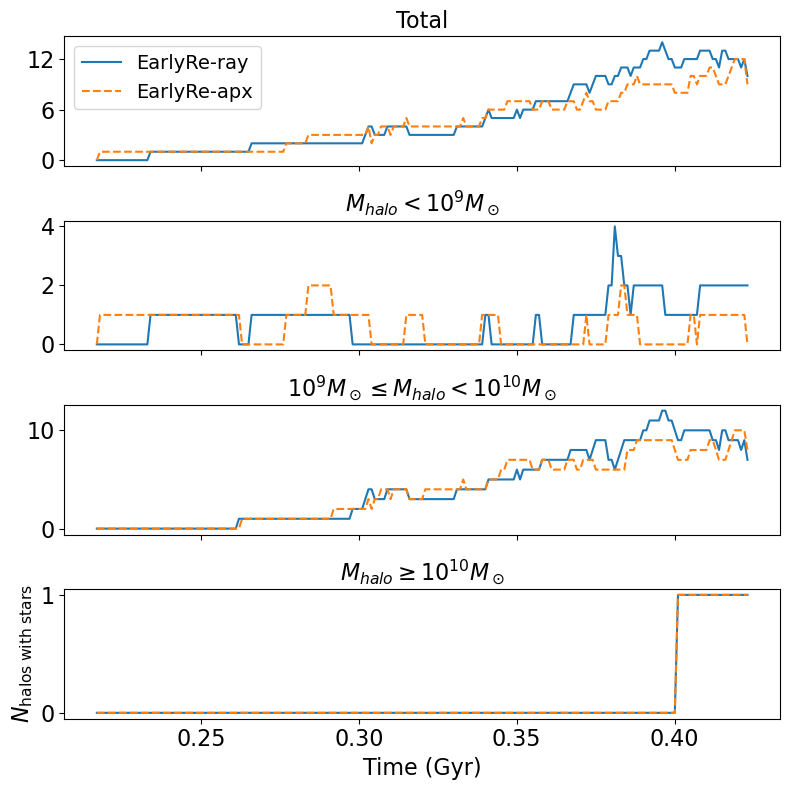

In [36]:
fig, axs = plt.subplots(ncols=1, nrows=4, sharex = True, figsize=(8,8))
axs[0].plot(time, ray_n_halowstars_total, label='EarlyRe-ray')
axs[0].plot(time, apx_n_halowstars_total, linestyle='--', label='EarlyRe-apx')
axs[0].set_title('Total', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].legend(fontsize=14)
axs[0].set_yticks([0,6,12])

axs[1].plot(time, ray_n_halowstars_range1)
axs[1].plot(time, apx_n_halowstars_range1, linestyle='--')
axs[1].set_title(r'$M_{halo} < 10^{9} M_\odot$', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[1].set_yticks([0,2,4])

axs[2].plot(time, ray_n_halowstars_range2)
axs[2].plot(time, apx_n_halowstars_range2, linestyle='--')
axs[2].set_title(r'$10^{9} M_\odot \leq M_{halo} < 10^{10} M_\odot$', fontsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=16)

axs[3].plot(time, ray_n_halowstars_range3)
axs[3].plot(time, apx_n_halowstars_range3, linestyle='--')
axs[3].set_title(r'$M_{halo} \geq 10^{10} M_\odot$', fontsize=16)
axs[3].set_yticks([0,1])
axs[3].set_xlabel('Time (Gyr)', fontsize=16)
axs[3].set_ylabel(r'$N_{\mathrm{halos\;with\;stars}}$', fontsize=16)
axs[3].tick_params(axis='both', which='major', labelsize=16)

fig.tight_layout()

plt.savefig('/work/hdd/bbvl/tnguyen2/figures/self-shielding/number_of_halo_wstars.png', dpi=300)

In [38]:
def halom_sm_sfr(idx, sassign, rawtree, tree):
    halom = []
    sm = []
    sfr =[]
    redshift = tree['0'][idx]['redshift']
    for branch in sassign[idx].keys():
        if sassign[idx][branch]['total_mass'] > 0:
            sm.append(sassign[idx][branch]['total_mass'])
            halom.append(rawtree[branch][int(idx)]['Halo_Mass'])
            sfr.append(sassign[idx][branch]['sfr'])
    return halom, sm, sfr, redshift

In [43]:
ray_halom1, ray_sm1, ray_sfr1, redshift1 = halom_sm_sfr('108', ray_sassign, ray_rawtree, ray_tree)
ray_halom, ray_sm, ray_sfr, redshift = halom_sm_sfr('211', ray_sassign, ray_rawtree, ray_tree)
ray_halom0, ray_sm0, ray_sfr0, redshift0 = halom_sm_sfr('5', ray_sassign, ray_rawtree, ray_tree)
apx_halom1, apx_sm1, apx_sfr1, redshift1 = halom_sm_sfr('108', apx_sassign, apx_rawtree, apx_tree)
apx_halom, apx_sm, apx_sfr, redshift = halom_sm_sfr('211', apx_sassign, apx_rawtree, apx_tree)
apx_halom0, apx_sm0, apx_sfr0, redshift0 = halom_sm_sfr('5', apx_sassign, apx_rawtree, apx_tree)

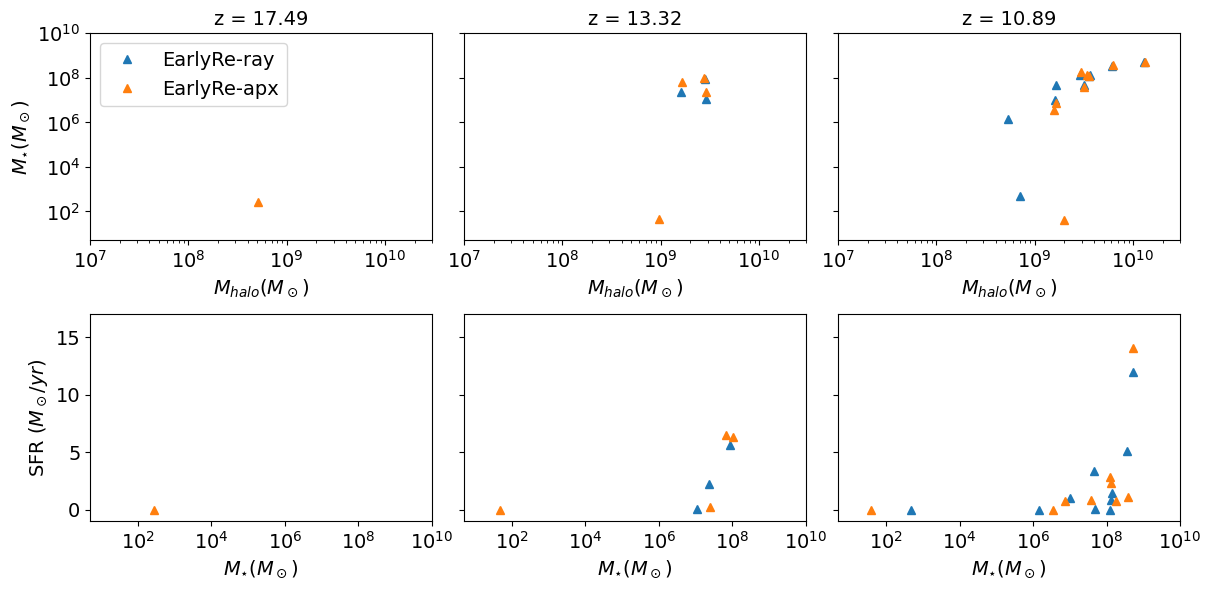

In [50]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, sharey = 'row', figsize=(12,6))

axs[0,0].plot(ray_halom0, ray_sm0,'^',label='EarlyRe-ray')
axs[0,0].plot(apx_halom0, apx_sm0,'^',label='EarlyRe-apx')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].set_xlabel(r'$M_{halo} (M_\odot)$', fontsize=14)
axs[0,0].set_ylabel(r'$M_{\star} (M_\odot)$', fontsize=14)
axs[0,0].set_ylim([0.5e1,1e10])
axs[0,0].set_xlim(1e7,3e10)
axs[0,0].set_title('z = %.2f' % redshift0, fontsize=14)
#plt.xticks([1e6,1e7,1e8,1e9,1e10])
axs[0,0].legend(loc='upper left', fontsize=14)
axs[0,0].tick_params(axis='both', which='major', labelsize=14)

axs[1,0].plot(ray_sm0, ray_sfr0,'^',label='EarlyRe-ray')
axs[1,0].plot(apx_sm0, apx_sfr0,'^',label='EarlyRe-apx')
axs[1,0].set_xscale('log')
axs[1,0].set_xlabel(r'$M_{\star} (M_\odot)$', fontsize=14)
axs[1,0].set_ylabel(r'SFR ($M_\odot/yr$)', fontsize=14)
axs[1,0].set_xlim([0.5e1,1e10])
axs[1,0].set_ylim([-1,17])
axs[1,0].tick_params(axis='both', which='major', labelsize=14)

#------------------------------------------------------------------

axs[0,1].plot(ray_halom1, ray_sm1,'^',label='EarlyRe-ray')
axs[0,1].plot(apx_halom1, apx_sm1,'^',label='EarlyRe-apx')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].set_xlabel(r'$M_{halo} (M_\odot)$', fontsize=14)
axs[0,1].set_ylim([0.5e1,1e10])
axs[0,1].set_xlim(1e7,3e10)
axs[0,1].set_title('z = %.2f' % redshift1, fontsize=14)
axs[0,1].tick_params(axis='both', which='major', labelsize=14)

axs[1,1].plot(ray_sm1, ray_sfr1,'^',label='EarlyRe-ray')
axs[1,1].plot(apx_sm1, apx_sfr1,'^',label='EarlyRe-apx')
axs[1,1].set_xscale('log')
axs[1,1].set_xlabel(r'$M_{\star} (M_\odot)$', fontsize=14)
axs[1,1].set_xlim([0.5e1,1e10])
axs[1,1].set_ylim([-1,17])
axs[1,1].tick_params(axis='both', which='major', labelsize=14)

#------------------------------------------------------------------

axs[0,2].plot(ray_halom, ray_sm,'^',label='EarlyRe-ray')
axs[0,2].plot(apx_halom, apx_sm,'^',label='EarlyRe-apx')
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].set_xlabel(r'$M_{halo} (M_\odot)$', fontsize=14)
axs[0,2].set_ylim([0.5e1,1e10])
axs[0,2].set_xlim(1e7,3e10)
axs[0,2].set_title('z = %.2f' % redshift, fontsize=14)
axs[0,2].tick_params(axis='both', which='major', labelsize=14)

axs[1,2].plot(ray_sm, ray_sfr,'^',label='EarlyRe-ray')
axs[1,2].plot(apx_sm, apx_sfr,'^',label='EarlyRe-apx')
axs[1,2].set_xscale('log')
axs[1,2].set_xlabel(r'$M_{\star} (M_\odot)$', fontsize=14)
axs[1,2].set_xlim([0.5e1,1e10])
axs[1,2].set_ylim([-1,17])
axs[1,2].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

#plt.savefig('/work/hdd/bbvl/tnguyen2/figures/self-shielding/SFR_stellarmass_totalmass_EarlyRe_starassignment.png', dpi=300)

In [4]:
def search_closest_upper(value, array):
    diff = array - value
    return np.where(diff >= 0)[0][0]

In [3]:
ray_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
apx_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()

In [3]:
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()
apx_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/pfs_allsnaps_1088.txt', dtype=str).tolist()

In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
#apx_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final.npy', allow_pickle=True).tolist()

In [4]:
time_list = np.array([ray_tree['0'][key]['time'] for key in ray_tree['0'].keys()])
idx_list = np.array([int(key) for key in ray_tree['0'].keys()])

In [5]:
ray_halo_wstars = {}
apx_halo_wstars = {}

In [7]:
idx = '170'

ray_halo_wstars_pos = np.empty(shape=(0,3))
ray_halo_wstars_rvir = np.array([])
ray_halo_wstars_branch = np.array([])
#ray_halo_wstars_dmmass = np.empty(shape=(0,1))

for key, vals in ray_tree.items():
    if idx in vals.keys() and vals[idx]['star_mass'] > 1:
        ray_halo_wstars[key] = vals[idx]
        ray_halo_wstars_pos = np.vstack((ray_halo_wstars_pos, vals[idx]['coor']))
        ray_halo_wstars_rvir = np.append(ray_halo_wstars_rvir, vals[idx]['Rvir'])
        ray_halo_wstars_branch = np.append(ray_halo_wstars_branch, key)
        
for key, vals in apx_tree.items():
    if idx in vals.keys() and vals[idx]['star_mass'] > 1:
        apx_halo_wstars[key] = vals[idx]

In [8]:
#Locate the overlapping halos. 
#For these halos, the stellar mass from the Thinh_structure file can be double counted. Therefore, we need to uniquely assign stars to each halo rather than loading the whole yt region.
overlap_pair = []
for i in range(len(ray_halo_wstars_branch)):
    for j in range(len(ray_halo_wstars_branch)):
        if (i == j) or sorted([ray_halo_wstars_branch[i],ray_halo_wstars_branch[j]]) in overlap_pair:
            continue
        else:
            if np.linalg.norm(ray_halo_wstars_pos[i] - ray_halo_wstars_pos[j]) < (ray_halo_wstars_rvir[i] + ray_halo_wstars_rvir[j]): #overlapping condition
                overlap_pair.append(sorted([ray_halo_wstars_branch[i],ray_halo_wstars_branch[j]]))

overlap_group = []
for pair in overlap_pair:
    if pair == overlap_pair[0]:
        group = pair
    else:
        if (pair[0] in group) or (pair[1] in group):
            group = list(set(group + pair))
        else:
            overlap_group.append(group)
            group = pair

In [9]:
#These are the groups of halos that need to be disentangled in terms of stellar mass
overlap_group

[['0_20', '0_21', '0', '0_16', '0_18', '0_19', '0_4', '0_2'],
 ['1', '1_14', '1_10'],
 ['3_1', '3', '3_7'],
 ['5', '5_1']]

In [76]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [79]:
group_test = np.array(overlap_group[0])
group_velcom = np.array([ray_rawtree[group_i][int(idx)]['Vel_Com'] for group_i in group_test])
#convert the unit of halo velocity from code_length/s to km/s
ds = yt.load(ray_pfs[int(idx)])
group_velcom = (group_velcom*ds.units.code_length/ds.units.s).to('km/s').v
group_starID = {}
allstars = []
for halo in group_test:
    halo_center = ray_tree[halo][idx]['coor']
    halo_radius = ray_tree[halo][idx]['Rvir']
    boolean = np.linalg.norm(ray_pos_all - halo_center, axis=1) < halo_radius
    group_starID[halo] = ray_ID_all[boolean].astype(int)
    allstars = list(set(allstars + list(ray_ID_all[boolean].astype(int))))
allstars = np.array(group_allstars)

yt : [INFO     ] 2024-12-10 10:23:52,751 Parameters: current_time              = 19.025726364245
yt : [INFO     ] 2024-12-10 10:23:52,752 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-10 10:23:52,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-10 10:23:52,762 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-10 10:23:52,765 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-10 10:23:52,768 Parameters: current_redshift          = 11.378797765779
yt : [INFO     ] 2024-12-10 10:23:52,770 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-10 10:23:52,773 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-10 10:23:52,774 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-10 10:23:52,774 Parameters: hubble_constant           = 0.679


In [32]:
group_starID

{'0_20': array([65363538, 65364102, 65364638, 65364670, 65364748]),
 '0_21': array([65731297, 65734353, 65734354, 65734355, 65734356, 65734357,
        65734358, 65734359, 65734360, 65734362, 65734363, 65734364,
        65734366]),
 '0': array([65363541, 65363542, 65364086, ..., 65665931, 65665937, 65724384]),
 '0_16': array([65363537, 65363546, 65363851, ..., 65665931, 65665937, 65724384]),
 '0_18': array([65363541, 65363542, 65364086, 65364088, 65364194, 65364698,
        65364664, 65364679, 65364681, 65614185, 65614414, 65617205,
        65659343, 65363652, 65363539, 65363540, 65363665, 65363673,
        65363674, 65363767, 65363773]),
 '0_19': array([65363541, 65363542, 65364086, 65364113, 65364693, 65364695,
        65364700, 65363652, 65363826, 65363539, 65363540, 65363665,
        65363673, 65363683, 65363767, 65363773, 65363831, 65364106]),
 '0_4': array([65364088, 65364194, 65364127, 65364129]),
 '0_2': array([65731297, 65734353, 65734354, 65734355, 65734356, 65734357,
       

In [33]:
allstars

array([65732608, 65658881, 65658882, ..., 65363965, 65724414, 65732607])

In [46]:
count_list = {}
for ID in allstars:
    count = 0
    branch_overlap = []
    for branch in group_starID.keys():
        if ID in group_starID[branch]:
            count += 1
            branch_overlap.append(branch)
    if count > 1:
        count_list[ID] = [count, branch_overlap]

In [85]:
ray_vel_all[ray_ID_all == 65732608]

array([[-65.81759841,  12.10400267, 120.21314368]])

In [90]:
ray_rawtree['0'][171]

{'NumParts': 10324,
 'Halo_Mass': 7628372984.201647,
 'Halo_Radius': 0.003219896406693052,
 'cden': 202.11934833096655,
 'r100': 0.0038463181360783145,
 'r150': 0.0036909953190874156,
 'r200': 0.003237456954225626,
 'r250': 0.0028894798550874417,
 'r300': 0.0026477752928777674,
 'r500': 0.0020518783497319,
 'r700': 0.001687430599046631,
 'Halo_Center': array([0.49444511, 0.50351903, 0.51216658]),
 'Vel_Com': array([-7.90055792e-19, -4.80827245e-20,  1.03378648e-19])}

In [86]:
count_list[65732608]

[2, ['0', '0_16']]

In [88]:
group_velcom[group_test == '0']

array([[-35.6028203 ,  -4.23333669,  10.90924301]])

In [89]:
group_velcom[group_test == '0_16']

array([[  8.91740217, -44.69326534,  60.8857723 ]])

In [65]:
group_test

['0_20', '0_21', '0_4', '0_16', '0', '0_18', '0_19', '0_2']

In [14]:
ray_pos_all.shape

(30056, 3)

In [17]:
ray_halo_wstars_pos

array([[0.49420246, 0.50316925, 0.51266823],
       [0.49296721, 0.50155015, 0.51324955],
       [0.47673882, 0.50389487, 0.5022506 ],
       [0.48908694, 0.50969391, 0.50063493],
       [0.50191681, 0.51200992, 0.53478709],
       [0.50191068, 0.51098171, 0.53401179],
       [0.50015472, 0.49932791, 0.512181  ],
       [0.48527808, 0.4967556 , 0.51121502],
       [0.50025661, 0.50790924, 0.53018027],
       [0.49264434, 0.51777617, 0.49249299],
       [0.48658425, 0.52111066, 0.52580045],
       [0.5022803 , 0.51522828, 0.53829083],
       [0.50312778, 0.51599952, 0.53952004]])

In [21]:
ray_halo_wstars.keys()

dict_keys(['0', '0_2', '1', '3', '4', '4_0', '5', '6', '8', '9', '18', '20', '69'])

In [22]:
ray_halo_wstars['0_2']

{'tree_loc': '0_2',
 'coor': array([0.49296721, 0.50155015, 0.51324955]),
 'Rvir': 0.0014047493591527603,
 'redshift': 10.886019680253,
 'time': 0.42308436376385633,
 'gas_mass': 170519124.77518892,
 'gas_mass_frac': 0.12780071866170767,
 'h2_mass': 5220394.575481022,
 'h2_fraction': 0.030614715987802243,
 'dm_mass': 1162249229.1687708,
 'pop2_mass': 1489589.9787338013,
 'pop3_mass': 5.17818883535532,
 'star_mass': 1489595.1569226366,
 'metal_mass': 14570.536272090665,
 'metallicity': 8.544810613648377e-05,
 'sfr': 0.0,
 'total_mass': 1334257949.1008823}

We need to assign each star to a unique halo. This can be done by tracking back the star's position when it first forms to see if it forms inside the same halo

In [8]:
ray_halo_idx = '0'
ray_halo_center = ray_tree[ray_halo_idx][idx]['coor']
ray_halo_rvir = ray_tree[ray_halo_idx][idx]['Rvir']

In [9]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())

In [10]:
halo_star_pos = ray_pos_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]
halo_star_age = ray_age_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]
halo_star_ID = ray_ID_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]

In [15]:
ftime_dict = {}
for j in range(len(halo_star_age)):
    ftime = time_list[-1] - halo_star_age[j]
    ftime_snapidx = idx_list[search_closest_upper(ftime, time_list)]
    try:
        ftime_dict[ftime_snapidx].append(int(halo_star_ID[j]))
    except:
        ftime_dict[ftime_snapidx] = []
        ftime_dict[ftime_snapidx].append(int(halo_star_ID[j]))

In [18]:
ftime_dict.keys()

dict_keys([80, 95, 117, 122, 124, 125, 154, 158, 159, 176, 190, 193, 194, 195, 201, 203, 130, 79, 156, 163, 198, 199, 114, 118, 200, 99, 109, 111, 112, 116, 119, 120, 121, 123, 127, 129, 131, 133, 134, 137, 138, 139, 141, 142, 143, 144, 160, 161, 175, 184, 202, 126, 150, 152, 162, 164, 169, 170, 174, 177, 178, 179, 183, 187, 191, 192, 204, 165, 180, 205, 206, 207, 208, 182, 209, 210, 211])

### Star Assignment Technique by Thinh

Starting from the earlier snapshot to the later snapshot. If a star particle is formed in a halo, assume that it will not escape that halo (there is a chance that during fly by, a DM halo can still some star particles, but since we are investigating star formation in halo, this can be neglected). If that halo is a sub branch, the star particle will belong to the main branch at the time step of merging. If a star particle is formed between the region of multiple halos, use energy definition to determine which halo it belongs to (choose the halo in which the star particle has the lowest total energy)

In [5]:
ray_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()

In [6]:
output = {}
for idx in ray_tree['0'].keys():
    output[str(idx)] = {}

In [8]:
def list_of_halos_wstars_idx(tree, idx):
    halo_wstars_pos = np.empty(shape=(0,3))
    halo_wstars_rvir = np.array([])
    halo_wstars_branch = np.array([])
    for key, vals in tree.items():
        if idx in vals.keys() and vals[idx]['star_mass'] > 1:
            halo_wstars_pos = np.vstack((halo_wstars_pos, vals[idx]['coor']))
            halo_wstars_rvir = np.append(halo_wstars_rvir, vals[idx]['Rvir'])
            halo_wstars_branch = np.append(halo_wstars_branch, key)   
    return halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch

In [9]:
def univDen(ds):
    # Hubble constant
    H0 = ds.hubble_constant * 100 * u.km/u.s/u.Mpc
    H = H0**2 * (ds.omega_matter*(1 + ds.current_redshift)**3 + ds.omega_lambda)  # Technically H^2
    G = 6.67e-11 * u.m**3/u.s**2/u.kg
    # Density of the universe
    den = (3*H/(8*np.pi*G)).to("kg/m**3") / u.kg * u.m**3
    return den.value

def extract_char_radius(tree, branch, idx):
    oden_list = np.array([100, 150, 200, 250, 300, 500, 700])
    char_radius_list = np.array([])
    for oden in oden_list:
        key = 'r%s' % oden
        char_radius_list = np.append(char_radius_list, tree[branch][idx][key])
    return oden_list, char_radius_list

def find_total_E(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

"""
def find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is km and the unit of velocity is km/s
    #star_pos is an array of stellar positions, star_vel is an array of stellar velocity
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden_boolean = char_radius_list > star_r[:,np.newaxis]
    oden = np.array([])
    for j in range(len(oden_boolean)):
        oden = np.append(oden, oden_list[np.where(oden_boolean[j] == True)[0][-1]])
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E
"""

"\ndef find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):\n    #this function calculate the total orbital energy of a star around a halo\n    #the unit of position is km and the unit of velocity is km/s\n    #star_pos is an array of stellar positions, star_vel is an array of stellar velocity\n    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)\n    star_r = (star_r_codelength*ds.units.code_length).to('m').v\n    #\n    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v\n    star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)\n    #Kinetic energy\n    KE = 0.5*star_relvel_mag**2\n    #Approximate M(r < star_r) by using the overdensity\n    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)\n    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v\n    oden_boolean = char_radius_list > star_r[:,np.newaxis]\n    oden = np.array([])\n    for j in range(len(o

In [10]:
print_mode = False

#for idx in tqdm(range(21, 212)):
for idx in tqdm(ray_tree['0'].keys()):
    idx = str(idx)
    #
    ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
    ray_pos_all = ray_metadata['pos']
    ray_age_all = ray_metadata['age']
    ray_mass_all = ray_metadata['mass']
    ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
    if os.path.exists('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx) == True:
        ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
    else:
        ray_vel_all = np.empty(shape=(0,3))
    #
    if idx == list(ray_tree['0'].keys())[0]:
        ray_ID_all_prev = np.array([])
    #
    ray_ID_unassign = np.setdiff1d(ray_ID_all, ray_ID_all_prev)
    ray_pos_unassign = ray_pos_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
    ray_vel_unassign = ray_vel_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
    #Obtain the halos with stars
    halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
    #
    #The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
    halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
    #The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
    overlap_boolean = np.sum(halo_boolean, axis=1) 
    #
    ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
    halo_boolean_overlap = halo_boolean[overlap_boolean > 1]
    ray_ID_indp = ray_ID_unassign[overlap_boolean == 1]
    halo_boolean_indp = halo_boolean[overlap_boolean == 1]
    #
    #The list of stars in each halo's region
    starmap_ID = []
    for j in range(halo_boolean_indp.shape[1]):
        starmap_ID.append(ray_ID_indp[halo_boolean_indp[:,j]])
    #
    if len(ray_ID_overlap) > 0:
        ds = yt.load(ray_pfs[int(idx)])
        ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
        ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
        overlap_branch_total = []
        for k in range(len(ray_ID_overlap)):
            overlap_branch = halo_wstars_branch[halo_boolean_overlap[k]]
            E_list = np.array([])
            for branch in overlap_branch:
                overlap_branch_total.append(branch)
                E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
                E_list = np.append(E_list, E)
            bound_branch = overlap_branch[np.argmin(E_list)]
            #print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch)
            starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])
        print('OVERLAP DETECTED AT BRANCHES', set(overlap_branch_total))
    len_starmap = [len(i) for i in starmap_ID]
    #
    for i in range(len(halo_wstars_branch)):
        if len(starmap_ID[i]) > 0: 
            for j in ray_tree[halo_wstars_branch[i]].keys(): #assuming when a star forms inside a halo, it will not leave that halo 
                if int(j) >= int(idx):
                    if halo_wstars_branch[i] not in output[j].keys():
                        output[j][halo_wstars_branch[i]] = starmap_ID[i]
                    else:
                        output[j][halo_wstars_branch[i]] = np.append(output[j][halo_wstars_branch[i]], starmap_ID[i])
            #for subbranch (or deeper sub-branch), the stars in that sub-branch will belong to the branch at lower level after the two halos merge
            nlevels = halo_wstars_branch[i].count('_')
            if nlevels > 1:
                print('DEEPER SUB-BRANCHES DETECTED')
            loop_branch = halo_wstars_branch[i]
            for level in range(nlevels): #add the stars in the sub-branch to higher branches
                deepest_lvl = loop_branch.split('_')[-1]
                mainbranch = loop_branch.split('_' + deepest_lvl)[0]
                merge_timestep = np.max(np.array(list(ray_tree[loop_branch].keys())).astype(int)) + 1
                last_timestep = np.max(np.array(list(ray_tree[mainbranch].keys())).astype(int))
                for j in range(merge_timestep, last_timestep + 1):
                    if mainbranch not in output[str(j)].keys():
                        output[str(j)][mainbranch] = starmap_ID[i]
                    else:
                        output[str(j)][mainbranch] = np.append(output[str(j)][mainbranch], starmap_ID[i])
                loop_branch = mainbranch
    #
    ray_ID_all_prev = ray_ID_all
    #
    if print_mode == True:
        print(idx, 'Number of total unassigned stars is:', len(ray_ID_unassign))
        print('Number of overlapped stars is', len(ray_ID_overlap), ', Number of independent stars is', len(ray_ID_indp))
        print('Halo with stars:', halo_wstars_branch)
        print('Number of assingned stars in each halo:', len_starmap, '\n')
        #print(starmap_ID,'\n')

 30%|███       | 63/208 [00:00<00:00, 189.97it/s]yt : [INFO     ] 2025-01-03 10:22:50,548 Parameters: current_time              = 13.577300752372
yt : [INFO     ] 2025-01-03 10:22:50,551 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:50,554 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:50,558 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:50,561 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:50,564 Parameters: current_redshift          = 14.502148247951
yt : [INFO     ] 2025-01-03 10:22:50,566 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:50,567 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:50,572 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:50,573 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'0_28', '0_28_2'}


yt : [INFO     ] 2025-01-03 10:22:54,247 Parameters: current_time              = 13.625093952372
yt : [INFO     ] 2025-01-03 10:22:54,250 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:54,252 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:54,254 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:54,255 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:54,259 Parameters: current_redshift          = 14.465868176248
yt : [INFO     ] 2025-01-03 10:22:54,261 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:54,264 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:54,266 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:54,266 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'0_28', '0_28_2'}


yt : [INFO     ] 2025-01-03 10:22:54,584 Parameters: current_time              = 13.672887152372
yt : [INFO     ] 2025-01-03 10:22:54,585 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:54,587 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:54,588 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:54,590 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:54,591 Parameters: current_redshift          = 14.429799355464
yt : [INFO     ] 2025-01-03 10:22:54,592 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:54,593 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:54,594 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:54,595 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'0_28', '0_28_2'}


yt : [INFO     ] 2025-01-03 10:22:55,159 Parameters: current_time              = 13.720680352372
yt : [INFO     ] 2025-01-03 10:22:55,160 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:55,162 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:55,163 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:55,165 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:55,166 Parameters: current_redshift          = 14.393940015767
yt : [INFO     ] 2025-01-03 10:22:55,167 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:55,167 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:55,168 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:55,169 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'0_28', '0_28_2'}


yt : [INFO     ] 2025-01-03 10:22:55,544 Parameters: current_time              = 13.768473552372
yt : [INFO     ] 2025-01-03 10:22:55,547 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:55,550 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:55,552 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:55,555 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:55,558 Parameters: current_redshift          = 14.358288272151
yt : [INFO     ] 2025-01-03 10:22:55,560 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:55,563 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:55,564 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:55,564 Parameters: hubble_constant           = 0.679
 40%|███▉      | 83/208 [00:05<00:13,  9.25it/s] 

OVERLAP DETECTED AT BRANCHES {'0_28', '0_28_2'}


yt : [INFO     ] 2025-01-03 10:22:55,859 Parameters: current_time              = 14.341991952372
yt : [INFO     ] 2025-01-03 10:22:55,862 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:55,865 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:55,868 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:55,871 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:55,874 Parameters: current_redshift          = 13.945982387121
yt : [INFO     ] 2025-01-03 10:22:55,876 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:55,879 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:55,880 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:55,880 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'1', '1_21'}


yt : [INFO     ] 2025-01-03 10:22:56,246 Parameters: current_time              = 14.485371552372
yt : [INFO     ] 2025-01-03 10:22:56,252 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:56,255 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:56,258 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:56,262 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:56,265 Parameters: current_redshift          = 13.847170787531
yt : [INFO     ] 2025-01-03 10:22:56,268 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:56,271 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:56,272 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:56,272 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'1', '1_21'}


yt : [INFO     ] 2025-01-03 10:22:56,548 Parameters: current_time              = 14.676544352372
yt : [INFO     ] 2025-01-03 10:22:56,554 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:56,558 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:56,561 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:56,565 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:56,568 Parameters: current_redshift          = 13.717928830255
yt : [INFO     ] 2025-01-03 10:22:56,571 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:56,574 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:56,575 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:56,575 Parameters: hubble_constant           = 0.679
 46%|████▌     | 95/208 [00:06<00:11,  9.53it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_28_0', '0_28'}


yt : [INFO     ] 2025-01-03 10:22:57,000 Parameters: current_time              = 14.867717152372
yt : [INFO     ] 2025-01-03 10:22:57,006 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:57,009 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:57,013 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:57,016 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:57,019 Parameters: current_redshift          = 13.591462314064
yt : [INFO     ] 2025-01-03 10:22:57,022 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:57,023 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:57,024 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:57,024 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'0', '6', '0_28', '6_6'}


yt : [INFO     ] 2025-01-03 10:22:57,370 Parameters: current_time              = 14.915510352372
yt : [INFO     ] 2025-01-03 10:22:57,376 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:57,379 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:57,382 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:57,386 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:57,389 Parameters: current_redshift          = 13.560268072475
yt : [INFO     ] 2025-01-03 10:22:57,390 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:57,395 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:57,396 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:57,396 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'6', '6_5', '6_6'}


yt : [INFO     ] 2025-01-03 10:22:57,752 Parameters: current_time              = 14.963303552372
yt : [INFO     ] 2025-01-03 10:22:57,758 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:57,761 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:57,765 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:57,768 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:57,771 Parameters: current_redshift          = 13.529239994525
yt : [INFO     ] 2025-01-03 10:22:57,772 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:57,773 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:57,780 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:57,781 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'6_5_0', '6', '6_5'}


yt : [INFO     ] 2025-01-03 10:22:58,176 Parameters: current_time              = 15.011096752372
yt : [INFO     ] 2025-01-03 10:22:58,178 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:58,180 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:58,182 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:58,184 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:58,185 Parameters: current_redshift          = 13.498376668599
yt : [INFO     ] 2025-01-03 10:22:58,186 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:58,200 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:58,201 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:58,201 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'6_5_0', '6', '6_5'}


yt : [INFO     ] 2025-01-03 10:22:58,602 Parameters: current_time              = 15.058889952372
yt : [INFO     ] 2025-01-03 10:22:58,608 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:58,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:58,618 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:58,622 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:58,623 Parameters: current_redshift          = 13.46767669952
yt : [INFO     ] 2025-01-03 10:22:58,624 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:58,625 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:58,625 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:58,626 Parameters: hubble_constant           = 0.679
 50%|████▉     | 103/208 [00:09<00:15,  6.75it/s]

OVERLAP DETECTED AT BRANCHES {'6', '6_5'}


yt : [INFO     ] 2025-01-03 10:22:59,623 Parameters: current_time              = 15.345649152372
yt : [INFO     ] 2025-01-03 10:22:59,627 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:22:59,629 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:22:59,631 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:22:59,633 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:22:59,635 Parameters: current_redshift          = 13.28682981258
yt : [INFO     ] 2025-01-03 10:22:59,637 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:22:59,639 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:22:59,640 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:22:59,642 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 10:22:59,945 Parameters: current_time              = 15.393442352372
yt

OVERLAP DETECTED AT BRANCHES {'1_19', '1'}
OVERLAP DETECTED AT BRANCHES {'1_19', '1'}


yt : [INFO     ] 2025-01-03 10:23:00,185 Parameters: current_time              = 15.441235552372
yt : [INFO     ] 2025-01-03 10:23:00,187 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:00,189 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:00,191 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:00,193 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:00,195 Parameters: current_redshift          = 13.227793547563
yt : [INFO     ] 2025-01-03 10:23:00,197 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:00,199 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:00,202 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:00,204 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 10:23:00,889 Parameters: current_time              = 15.489028752372
y

OVERLAP DETECTED AT BRANCHES {'1_19', '1'}
OVERLAP DETECTED AT BRANCHES {'1_19', '1'}


 52%|█████▏    | 109/208 [00:11<00:16,  5.94it/s]yt : [INFO     ] 2025-01-03 10:23:01,219 Parameters: current_time              = 15.536821952372
yt : [INFO     ] 2025-01-03 10:23:01,221 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:01,223 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:01,225 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:01,227 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:01,229 Parameters: current_redshift          = 13.16936268292
yt : [INFO     ] 2025-01-03 10:23:01,231 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:01,233 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:01,235 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:01,237 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 10:23:01,632 Parameter

OVERLAP DETECTED AT BRANCHES {'1_19', '1'}
OVERLAP DETECTED AT BRANCHES {'0', '0_27'}


yt : [INFO     ] 2025-01-03 10:23:01,896 Parameters: current_time              = 15.632408352372
yt : [INFO     ] 2025-01-03 10:23:01,899 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:01,901 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:01,903 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:01,905 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:01,907 Parameters: current_redshift          = 13.111527962699
yt : [INFO     ] 2025-01-03 10:23:01,909 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:01,910 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:01,912 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:01,914 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 10:23:02,167 Parameters: current_time              = 15.680201552372


OVERLAP DETECTED AT BRANCHES {'1_19', '1'}


yt : [INFO     ] 2025-01-03 10:23:02,172 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:02,174 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:02,176 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:02,179 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:02,181 Parameters: current_redshift          = 13.082831125817
yt : [INFO     ] 2025-01-03 10:23:02,183 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:02,185 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:02,188 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:02,188 Parameters: hubble_constant           = 0.679
 54%|█████▍    | 113/208 [00:12<00:18,  5.16it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_27'}


yt : [INFO     ] 2025-01-03 10:23:02,697 Parameters: current_time              = 15.727994752372
yt : [INFO     ] 2025-01-03 10:23:02,703 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:02,706 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:02,709 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:02,712 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:02,715 Parameters: current_redshift          = 13.054279714961
yt : [INFO     ] 2025-01-03 10:23:02,718 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:02,721 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:02,724 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:02,724 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'0', '0_27'}


yt : [INFO     ] 2025-01-03 10:23:03,625 Parameters: current_time              = 15.775787952372
yt : [INFO     ] 2025-01-03 10:23:03,630 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:03,633 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:03,636 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:03,638 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:03,641 Parameters: current_redshift          = 13.025872475203
yt : [INFO     ] 2025-01-03 10:23:03,643 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:03,646 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:03,647 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:03,647 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 10:23:03,871 Parameters: current_time              = 15.823581152372
y

OVERLAP DETECTED AT BRANCHES {'0', '0_25'}


yt : [INFO     ] 2025-01-03 10:23:03,888 Parameters: current_redshift          = 12.997608083485
yt : [INFO     ] 2025-01-03 10:23:03,891 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:03,892 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:03,893 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:03,893 Parameters: hubble_constant           = 0.679
 56%|█████▌    | 116/208 [00:14<00:22,  4.16it/s]yt : [INFO     ] 2025-01-03 10:23:04,288 Parameters: current_time              = 15.871374352372
yt : [INFO     ] 2025-01-03 10:23:04,291 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:04,294 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:04,297 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:04,300 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:04,302 Paramete

OVERLAP DETECTED AT BRANCHES {'0', '0_25'}


yt : [INFO     ] 2025-01-03 10:23:04,661 Parameters: current_time              = 15.919167552372


OVERLAP DETECTED AT BRANCHES {'0', '0_25'}


yt : [INFO     ] 2025-01-03 10:23:04,666 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:04,669 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:04,672 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:04,676 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:04,679 Parameters: current_redshift          = 12.941503984732
yt : [INFO     ] 2025-01-03 10:23:04,679 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:04,680 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:04,681 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:04,690 Parameters: hubble_constant           = 0.679
 57%|█████▋    | 118/208 [00:14<00:22,  4.05it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_25'}


yt : [INFO     ] 2025-01-03 10:23:05,022 Parameters: current_time              = 16.205926752372
yt : [INFO     ] 2025-01-03 10:23:05,025 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:05,029 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:05,032 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:05,035 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:05,038 Parameters: current_redshift          = 12.776508102889
yt : [INFO     ] 2025-01-03 10:23:05,042 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:05,042 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:05,043 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:05,044 Parameters: hubble_constant           = 0.679
 60%|█████▉    | 124/208 [00:15<00:16,  5.04it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_20'}


yt : [INFO     ] 2025-01-03 10:23:05,534 Parameters: current_time              = 16.301513152372
yt : [INFO     ] 2025-01-03 10:23:05,538 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:05,541 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:05,544 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:05,547 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:05,550 Parameters: current_redshift          = 12.722585949442
yt : [INFO     ] 2025-01-03 10:23:05,553 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:05,554 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:05,555 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:05,556 Parameters: hubble_constant           = 0.679
 61%|██████    | 126/208 [00:15<00:16,  5.09it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_20'}


yt : [INFO     ] 2025-01-03 10:23:05,860 Parameters: current_time              = 16.349306352372
yt : [INFO     ] 2025-01-03 10:23:05,866 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:05,869 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:05,873 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:05,876 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:05,879 Parameters: current_redshift          = 12.695822059203
yt : [INFO     ] 2025-01-03 10:23:05,882 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:05,883 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:05,883 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:05,884 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 10:23:06,202 Parameters: current_time              = 16.397099552372
y

OVERLAP DETECTED AT BRANCHES {'0', '0_20'}


yt : [INFO     ] 2025-01-03 10:23:06,218 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:06,221 Parameters: current_redshift          = 12.669188263387
yt : [INFO     ] 2025-01-03 10:23:06,222 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:06,223 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:06,224 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:06,224 Parameters: hubble_constant           = 0.679
 62%|██████▏   | 128/208 [00:16<00:17,  4.60it/s]yt : [INFO     ] 2025-01-03 10:23:06,507 Parameters: current_time              = 16.444892752372


OVERLAP DETECTED AT BRANCHES {'0', '0_20'}


yt : [INFO     ] 2025-01-03 10:23:06,514 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:06,517 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:06,520 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:06,523 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:06,527 Parameters: current_redshift          = 12.642683462314
yt : [INFO     ] 2025-01-03 10:23:06,527 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:06,528 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:06,529 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:06,529 Parameters: hubble_constant           = 0.679
 62%|██████▏   | 129/208 [00:16<00:18,  4.26it/s]

OVERLAP DETECTED AT BRANCHES {'3', '3_7'}


yt : [INFO     ] 2025-01-03 10:23:06,913 Parameters: current_time              = 16.492685952372
yt : [INFO     ] 2025-01-03 10:23:06,918 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:06,921 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:06,924 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:06,927 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:06,930 Parameters: current_redshift          = 12.616306515898
yt : [INFO     ] 2025-01-03 10:23:06,933 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:06,934 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:06,935 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:06,935 Parameters: hubble_constant           = 0.679
 62%|██████▎   | 130/208 [00:17<00:21,  3.59it/s]

OVERLAP DETECTED AT BRANCHES {'3', '3_7'}


yt : [INFO     ] 2025-01-03 10:23:07,495 Parameters: current_time              = 16.683858752372
yt : [INFO     ] 2025-01-03 10:23:07,500 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:07,503 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:07,507 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:07,510 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:07,512 Parameters: current_redshift          = 12.512060033201
yt : [INFO     ] 2025-01-03 10:23:07,515 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:07,518 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:07,521 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:07,522 Parameters: hubble_constant           = 0.679
 64%|██████▍   | 134/208 [00:17<00:16,  4.59it/s]

OVERLAP DETECTED AT BRANCHES {'3', '3_7'}


yt : [INFO     ] 2025-01-03 10:23:08,027 Parameters: current_time              = 16.779445152372
yt : [INFO     ] 2025-01-03 10:23:08,033 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:08,036 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:08,039 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:08,042 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:08,045 Parameters: current_redshift          = 12.460680119598
yt : [INFO     ] 2025-01-03 10:23:08,048 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:08,048 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:08,049 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:08,049 Parameters: hubble_constant           = 0.679
 65%|██████▌   | 136/208 [00:18<00:14,  4.95it/s]

OVERLAP DETECTED AT BRANCHES {'3', '3_7'}


yt : [INFO     ] 2025-01-03 10:23:08,326 Parameters: current_time              = 16.827238352372
yt : [INFO     ] 2025-01-03 10:23:08,331 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:08,334 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:08,337 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:08,341 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:08,343 Parameters: current_redshift          = 12.435172399407
yt : [INFO     ] 2025-01-03 10:23:08,346 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:08,347 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:08,348 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:08,348 Parameters: hubble_constant           = 0.679
 66%|██████▌   | 137/208 [00:18<00:17,  4.09it/s]

OVERLAP DETECTED AT BRANCHES {'3', '3_7'}


yt : [INFO     ] 2025-01-03 10:23:08,860 Parameters: current_time              = 16.875031552372
yt : [INFO     ] 2025-01-03 10:23:08,865 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:08,868 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:08,871 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:08,874 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:08,877 Parameters: current_redshift          = 12.409785155589
yt : [INFO     ] 2025-01-03 10:23:08,880 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:08,881 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:08,881 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:08,882 Parameters: hubble_constant           = 0.679
 66%|██████▋   | 138/208 [00:19<00:21,  3.32it/s]

OVERLAP DETECTED AT BRANCHES {'3', '3_7'}


yt : [INFO     ] 2025-01-03 10:23:09,528 Parameters: current_time              = 16.922824752372
yt : [INFO     ] 2025-01-03 10:23:09,531 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:09,534 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:09,537 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:09,540 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:09,543 Parameters: current_redshift          = 12.384517480316
yt : [INFO     ] 2025-01-03 10:23:09,546 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:09,549 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:09,550 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:09,550 Parameters: hubble_constant           = 0.679
 67%|██████▋   | 139/208 [00:19<00:24,  2.81it/s]

OVERLAP DETECTED AT BRANCHES {'3_8', '3', '3_7'}


yt : [INFO     ] 2025-01-03 10:23:09,996 Parameters: current_time              = 17.018411152372
yt : [INFO     ] 2025-01-03 10:23:10,001 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:10,004 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:10,008 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:10,011 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:10,014 Parameters: current_redshift          = 12.334337250877
yt : [INFO     ] 2025-01-03 10:23:10,017 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:10,017 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:10,018 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:10,019 Parameters: hubble_constant           = 0.679
 68%|██████▊   | 141/208 [00:20<00:19,  3.40it/s]

OVERLAP DETECTED AT BRANCHES {'3_6', '3'}


yt : [INFO     ] 2025-01-03 10:23:10,412 Parameters: current_time              = 17.066204352372
yt : [INFO     ] 2025-01-03 10:23:10,418 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:10,421 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:10,424 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:10,427 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:10,431 Parameters: current_redshift          = 12.309422927464
yt : [INFO     ] 2025-01-03 10:23:10,431 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:10,432 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:10,433 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:10,433 Parameters: hubble_constant           = 0.679
 68%|██████▊   | 142/208 [00:20<00:19,  3.32it/s]

OVERLAP DETECTED AT BRANCHES {'1', '1_15'}


yt : [INFO     ] 2025-01-03 10:23:10,725 Parameters: current_time              = 17.161790752372
yt : [INFO     ] 2025-01-03 10:23:10,731 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:10,734 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:10,737 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:10,740 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:10,744 Parameters: current_redshift          = 12.259941270809
yt : [INFO     ] 2025-01-03 10:23:10,744 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:10,745 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:10,746 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:10,746 Parameters: hubble_constant           = 0.679
 69%|██████▉   | 144/208 [00:21<00:17,  3.75it/s]

OVERLAP DETECTED AT BRANCHES {'6', '6_3'}


yt : [INFO     ] 2025-01-03 10:23:11,091 Parameters: current_time              = 17.209583952372
yt : [INFO     ] 2025-01-03 10:23:11,096 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:11,100 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:11,103 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:11,106 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:11,109 Parameters: current_redshift          = 12.235372131807
yt : [INFO     ] 2025-01-03 10:23:11,110 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:11,116 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:11,116 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:11,117 Parameters: hubble_constant           = 0.679
 70%|██████▉   | 145/208 [00:21<00:17,  3.61it/s]

OVERLAP DETECTED AT BRANCHES {'1', '6', '1_15', '6_3'}


yt : [INFO     ] 2025-01-03 10:23:11,453 Parameters: current_time              = 17.305170352372
yt : [INFO     ] 2025-01-03 10:23:11,459 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:11,462 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:11,465 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:11,469 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:11,472 Parameters: current_redshift          = 12.186573432899
yt : [INFO     ] 2025-01-03 10:23:11,473 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:11,478 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:11,479 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:11,479 Parameters: hubble_constant           = 0.679
 71%|███████   | 147/208 [00:21<00:15,  3.93it/s]

OVERLAP DETECTED AT BRANCHES {'1', '1_15'}


yt : [INFO     ] 2025-01-03 10:23:11,856 Parameters: current_time              = 17.352963552372
yt : [INFO     ] 2025-01-03 10:23:11,862 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:11,865 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:11,868 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:11,871 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:11,875 Parameters: current_redshift          = 12.162342209146
yt : [INFO     ] 2025-01-03 10:23:11,878 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:11,881 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:11,881 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:11,882 Parameters: hubble_constant           = 0.679
 71%|███████   | 148/208 [00:22<00:15,  3.77it/s]

OVERLAP DETECTED AT BRANCHES {'1', '1_15'}


yt : [INFO     ] 2025-01-03 10:23:12,158 Parameters: current_time              = 17.400756752372
yt : [INFO     ] 2025-01-03 10:23:12,164 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:12,167 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:12,171 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:12,174 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:12,177 Parameters: current_redshift          = 12.138221973937
yt : [INFO     ] 2025-01-03 10:23:12,178 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:12,183 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:12,184 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:12,185 Parameters: hubble_constant           = 0.679
 72%|███████▏  | 149/208 [00:22<00:18,  3.13it/s]

OVERLAP DETECTED AT BRANCHES {'1', '1_15'}


yt : [INFO     ] 2025-01-03 10:23:12,672 Parameters: current_time              = 17.448549952372
yt : [INFO     ] 2025-01-03 10:23:12,678 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:12,681 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:12,684 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:12,688 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:12,691 Parameters: current_redshift          = 12.114211916145
yt : [INFO     ] 2025-01-03 10:23:12,694 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:12,695 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:12,696 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:12,696 Parameters: hubble_constant           = 0.679
 72%|███████▏  | 150/208 [00:23<00:20,  2.79it/s]

OVERLAP DETECTED AT BRANCHES {'5', '5_1'}


yt : [INFO     ] 2025-01-03 10:23:13,125 Parameters: current_time              = 17.496343152372
yt : [INFO     ] 2025-01-03 10:23:13,131 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:13,134 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:13,137 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:13,141 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:13,144 Parameters: current_redshift          = 12.090311162642
yt : [INFO     ] 2025-01-03 10:23:13,147 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:13,148 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:13,148 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:13,149 Parameters: hubble_constant           = 0.679
 73%|███████▎  | 151/208 [00:23<00:21,  2.67it/s]yt : [INFO     ] 2025-01-03 10:23:13,522 Paramete

OVERLAP DETECTED AT BRANCHES {'1', '1_15', '1_12'}


yt : [INFO     ] 2025-01-03 10:23:13,543 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:13,543 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:13,544 Parameters: hubble_constant           = 0.679
 73%|███████▎  | 152/208 [00:23<00:22,  2.54it/s]yt : [INFO     ] 2025-01-03 10:23:13,976 Parameters: current_time              = 17.591929552372
yt : [INFO     ] 2025-01-03 10:23:13,979 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:13,982 Parameters: domain_left_edge          = [0. 0. 0.]


OVERLAP DETECTED AT BRANCHES {'1', '1_15', '1_12'}


yt : [INFO     ] 2025-01-03 10:23:13,988 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:13,991 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:13,994 Parameters: current_redshift          = 12.042834087743
yt : [INFO     ] 2025-01-03 10:23:13,994 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:13,999 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:14,000 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:14,001 Parameters: hubble_constant           = 0.679
 74%|███████▎  | 153/208 [00:24<00:21,  2.53it/s]

OVERLAP DETECTED AT BRANCHES {'1', '1_15', '1_12'}


yt : [INFO     ] 2025-01-03 10:23:14,397 Parameters: current_time              = 17.639722752372
yt : [INFO     ] 2025-01-03 10:23:14,403 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:14,406 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:14,409 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:14,412 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:14,415 Parameters: current_redshift          = 12.019256462798
yt : [INFO     ] 2025-01-03 10:23:14,418 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:14,421 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:14,422 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:14,423 Parameters: hubble_constant           = 0.679
 74%|███████▍  | 154/208 [00:24<00:25,  2.12it/s]yt : [INFO     ] 2025-01-03 10:23:15,035 Paramete

OVERLAP DETECTED AT BRANCHES {'5', '5_0', '5_1', '1_12', '1'}


yt : [INFO     ] 2025-01-03 10:23:15,050 Parameters: current_redshift          = 11.995785081588
yt : [INFO     ] 2025-01-03 10:23:15,052 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:15,054 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:15,055 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:15,055 Parameters: hubble_constant           = 0.679
 75%|███████▍  | 155/208 [00:25<00:22,  2.39it/s]yt : [INFO     ] 2025-01-03 10:23:15,322 Parameters: current_time              = 17.735309152372
yt : [INFO     ] 2025-01-03 10:23:15,325 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:15,328 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:15,330 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:15,333 Parameters: cosmological_simulation   = 1


OVERLAP DETECTED AT BRANCHES {'0', '0_16'}


yt : [INFO     ] 2025-01-03 10:23:15,338 Parameters: current_redshift          = 11.972419180222
yt : [INFO     ] 2025-01-03 10:23:15,340 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:15,343 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:15,344 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:15,344 Parameters: hubble_constant           = 0.679
 75%|███████▌  | 156/208 [00:25<00:19,  2.61it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_16'}


yt : [INFO     ] 2025-01-03 10:23:15,648 Parameters: current_time              = 17.783102352372
yt : [INFO     ] 2025-01-03 10:23:15,654 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:15,657 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:15,660 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:15,663 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:15,666 Parameters: current_redshift          = 11.949158002339
yt : [INFO     ] 2025-01-03 10:23:15,669 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:15,669 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:15,670 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:15,671 Parameters: hubble_constant           = 0.679
 75%|███████▌  | 157/208 [00:26<00:25,  2.02it/s]

OVERLAP DETECTED AT BRANCHES {'5', '5_0', '5_1'}


yt : [INFO     ] 2025-01-03 10:23:16,432 Parameters: current_time              = 17.878688752372
yt : [INFO     ] 2025-01-03 10:23:16,438 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:16,441 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:16,444 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:16,447 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:16,450 Parameters: current_redshift          = 11.902946646669
yt : [INFO     ] 2025-01-03 10:23:16,453 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:16,456 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:16,458 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:16,459 Parameters: hubble_constant           = 0.679
 76%|███████▋  | 159/208 [00:26<00:16,  2.94it/s]yt : [INFO     ] 2025-01-03 10:23:16,707 Paramete

OVERLAP DETECTED AT BRANCHES {'4_9', '4', '4_10'}


yt : [INFO     ] 2025-01-03 10:23:16,714 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:16,717 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:16,720 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:16,723 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:16,726 Parameters: current_redshift          = 11.857144812054
yt : [INFO     ] 2025-01-03 10:23:16,728 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:16,731 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:16,734 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:16,734 Parameters: hubble_constant           = 0.679
 77%|███████▋  | 161/208 [00:27<00:13,  3.59it/s]

OVERLAP DETECTED AT BRANCHES {'4_9', '4', '4_10'}


yt : [INFO     ] 2025-01-03 10:23:17,127 Parameters: current_time              = 18.022068352372
yt : [INFO     ] 2025-01-03 10:23:17,133 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:17,136 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:17,139 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:17,143 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:17,146 Parameters: current_redshift          = 11.834395834977
yt : [INFO     ] 2025-01-03 10:23:17,147 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:17,147 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:17,148 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:17,148 Parameters: hubble_constant           = 0.679
 78%|███████▊  | 162/208 [00:27<00:13,  3.34it/s]yt : [INFO     ] 2025-01-03 10:23:17,434 Paramete

OVERLAP DETECTED AT BRANCHES {'4_9', '4', '4_10'}


yt : [INFO     ] 2025-01-03 10:23:17,454 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:17,455 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:17,455 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:17,456 Parameters: hubble_constant           = 0.679
 78%|███████▊  | 163/208 [00:28<00:17,  2.53it/s]yt : [INFO     ] 2025-01-03 10:23:18,107 Parameters: current_time              = 18.117654752372
yt : [INFO     ] 2025-01-03 10:23:18,109 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:18,112 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:18,115 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:18,117 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:18,120 Parameters: current_redshift          = 11.789198195603
yt : [INFO     ] 2025-01-03 10:23:18,122 Paramete

OVERLAP DETECTED AT BRANCHES {'1_12', '4_9', '1', '4', '1_12_0', '4_10'}
OVERLAP DETECTED AT BRANCHES {'4_3', '1_12', '4_9', '1', '4', '1_12_0', '4_10'}


 79%|███████▉  | 164/208 [00:28<00:19,  2.27it/s]yt : [INFO     ] 2025-01-03 10:23:18,682 Parameters: current_time              = 18.165447952372
yt : [INFO     ] 2025-01-03 10:23:18,684 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:18,686 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:18,688 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:18,690 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:18,692 Parameters: current_redshift          = 11.766748127689
yt : [INFO     ] 2025-01-03 10:23:18,694 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:18,696 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:18,698 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:18,700 Parameters: hubble_constant           = 0.679
 79%|███████▉  | 165/208 [00:29<00:26,  1.65it/s]

OVERLAP DETECTED AT BRANCHES {'5', '5_1', '4_3', '5_0', '1_12', '4_9', '1', '4', '1_12_0'}


 80%|███████▉  | 166/208 [00:30<00:28,  1.48it/s]yt : [INFO     ] 2025-01-03 10:23:20,607 Parameters: current_time              = 18.261034352372
yt : [INFO     ] 2025-01-03 10:23:20,609 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:20,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:20,613 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:20,615 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:20,617 Parameters: current_redshift          = 11.722141790593
yt : [INFO     ] 2025-01-03 10:23:20,618 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:20,620 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:20,622 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:20,623 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'5', '5_0', '5_1', '1_12', '1'}
OVERLAP DETECTED AT BRANCHES {'5', '5_0', '5_1', '4_3', '1_12', '1', '4'}


 80%|████████  | 167/208 [00:31<00:28,  1.45it/s]yt : [INFO     ] 2025-01-03 10:23:21,340 Parameters: current_time              = 18.308827552372
yt : [INFO     ] 2025-01-03 10:23:21,342 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:21,343 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:21,345 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:21,347 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:21,349 Parameters: current_redshift          = 11.699984062947
yt : [INFO     ] 2025-01-03 10:23:21,350 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:21,352 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:21,354 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:21,356 Parameters: hubble_constant           = 0.679
 81%|████████  | 168/208 [00:31<00:22,  1.75it/s]

OVERLAP DETECTED AT BRANCHES {'4', '4_3'}


yt : [INFO     ] 2025-01-03 10:23:21,686 Parameters: current_time              = 18.356620752372
yt : [INFO     ] 2025-01-03 10:23:21,688 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:21,690 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:21,692 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:21,694 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:21,696 Parameters: current_redshift          = 11.677922540957
yt : [INFO     ] 2025-01-03 10:23:21,698 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:21,700 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:21,701 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:21,703 Parameters: hubble_constant           = 0.679
 81%|████████▏ | 169/208 [00:31<00:19,  2.02it/s]yt : [INFO     ] 2025-01-03 10:23:21,949 Paramete

OVERLAP DETECTED AT BRANCHES {'4', '4_8', '4_3'}


yt : [INFO     ] 2025-01-03 10:23:21,958 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:21,961 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:21,963 Parameters: current_redshift          = 11.655956558057
yt : [INFO     ] 2025-01-03 10:23:21,965 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:21,967 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:21,969 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:21,970 Parameters: hubble_constant           = 0.679
 82%|████████▏ | 170/208 [00:32<00:19,  1.98it/s]

OVERLAP DETECTED AT BRANCHES {'4', '4_3'}


yt : [INFO     ] 2025-01-03 10:23:22,559 Parameters: current_time              = 18.452207152372
yt : [INFO     ] 2025-01-03 10:23:22,563 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:22,566 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:22,569 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:22,573 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:22,576 Parameters: current_redshift          = 11.634085454016
yt : [INFO     ] 2025-01-03 10:23:22,579 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:22,580 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:22,580 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:22,581 Parameters: hubble_constant           = 0.679
 82%|████████▏ | 171/208 [00:33<00:27,  1.36it/s]

OVERLAP DETECTED AT BRANCHES {'5', '5_0', '5_1', '4_3', '0', '0_8', '4', '0_12'}


yt : [INFO     ] 2025-01-03 10:23:23,814 Parameters: current_time              = 18.500000352372
yt : [INFO     ] 2025-01-03 10:23:23,818 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:23,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:23,823 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:23,825 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:23,827 Parameters: current_redshift          = 11.612308574862
yt : [INFO     ] 2025-01-03 10:23:23,829 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:23,831 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:23,834 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:23,836 Parameters: hubble_constant           = 0.679
 83%|████████▎ | 172/208 [00:34<00:25,  1.43it/s]yt : [INFO     ] 2025-01-03 10:23:24,367 Paramete

OVERLAP DETECTED AT BRANCHES {'4_3', '0', '0_8', '4', '0_11', '0_12'}


yt : [INFO     ] 2025-01-03 10:23:24,381 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:24,383 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:24,385 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:24,386 Parameters: hubble_constant           = 0.679
 83%|████████▎ | 173/208 [00:35<00:27,  1.27it/s]yt : [INFO     ] 2025-01-03 10:23:25,335 Parameters: current_time              = 18.595586752372
yt : [INFO     ] 2025-01-03 10:23:25,337 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:25,339 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:25,340 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:25,342 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:25,344 Parameters: current_redshift          = 11.569034906154
yt : [INFO     ] 2025-01-03 10:23:25,346 Paramete

OVERLAP DETECTED AT BRANCHES {'4_3', '0', '0_8', '4', '0_11', '0_12'}
OVERLAP DETECTED AT BRANCHES {'4_3', '0', '0_8', '4', '0_11', '0_12'}


 84%|████████▎ | 174/208 [00:35<00:21,  1.58it/s]yt : [INFO     ] 2025-01-03 10:23:25,611 Parameters: current_time              = 18.643379952372
yt : [INFO     ] 2025-01-03 10:23:25,613 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:25,615 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:25,617 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:25,619 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:25,620 Parameters: current_redshift          = 11.547536593051
yt : [INFO     ] 2025-01-03 10:23:25,622 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:25,624 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:25,626 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:25,627 Parameters: hubble_constant           = 0.679
 84%|████████▍ | 175/208 [00:35<00:18,  1.81it/s]

OVERLAP DETECTED AT BRANCHES {'4_3', '0', '0_8', '4', '0_11', '0_12'}


yt : [INFO     ] 2025-01-03 10:23:27,139 Parameters: current_time              = 18.691173152372
yt : [INFO     ] 2025-01-03 10:23:27,142 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:27,146 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:27,149 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:27,152 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:27,155 Parameters: current_redshift          = 11.526129859509
yt : [INFO     ] 2025-01-03 10:23:27,158 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:27,159 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:27,160 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:27,161 Parameters: hubble_constant           = 0.679
 85%|████████▍ | 176/208 [00:37<00:28,  1.14it/s]

OVERLAP DETECTED AT BRANCHES {'4_3', '0', '0_8', '4', '0_11', '0_12'}


yt : [INFO     ] 2025-01-03 10:23:27,648 Parameters: current_time              = 18.738966352372
yt : [INFO     ] 2025-01-03 10:23:27,654 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:27,657 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:27,660 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:27,664 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:27,667 Parameters: current_redshift          = 11.504814174251
yt : [INFO     ] 2025-01-03 10:23:27,667 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:27,668 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:27,669 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:27,669 Parameters: hubble_constant           = 0.679
 85%|████████▌ | 177/208 [00:37<00:22,  1.41it/s]

OVERLAP DETECTED AT BRANCHES {'4_3', '0', '0_8', '4', '0_11', '0_12'}


yt : [INFO     ] 2025-01-03 10:23:27,989 Parameters: current_time              = 18.786759552372
yt : [INFO     ] 2025-01-03 10:23:27,995 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:27,998 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:28,002 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:28,005 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:28,008 Parameters: current_redshift          = 11.483588919289
yt : [INFO     ] 2025-01-03 10:23:28,009 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:28,009 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:28,010 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:28,011 Parameters: hubble_constant           = 0.679
 86%|████████▌ | 178/208 [00:38<00:17,  1.69it/s]

OVERLAP DETECTED AT BRANCHES {'4', '4_3'}


yt : [INFO     ] 2025-01-03 10:23:28,342 Parameters: current_time              = 18.834552752372
yt : [INFO     ] 2025-01-03 10:23:28,348 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:28,352 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:28,355 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:28,358 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:28,361 Parameters: current_redshift          = 11.462453482384
yt : [INFO     ] 2025-01-03 10:23:28,364 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:28,367 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:28,368 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:28,369 Parameters: hubble_constant           = 0.679
 86%|████████▌ | 179/208 [00:38<00:16,  1.72it/s]

OVERLAP DETECTED AT BRANCHES {'4_3', '0', '0_8', '4', '0_11', '0_12'}


yt : [INFO     ] 2025-01-03 10:23:28,906 Parameters: current_time              = 18.882345952372
yt : [INFO     ] 2025-01-03 10:23:28,912 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:28,915 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:28,919 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:28,922 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:28,925 Parameters: current_redshift          = 11.441407256985
yt : [INFO     ] 2025-01-03 10:23:28,928 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:28,931 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:28,932 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:28,933 Parameters: hubble_constant           = 0.679
 87%|████████▋ | 180/208 [00:39<00:19,  1.43it/s]

OVERLAP DETECTED AT BRANCHES {'4_3', '0', '0_8', '4', '0_11', '0_12'}


yt : [INFO     ] 2025-01-03 10:23:29,836 Parameters: current_time              = 18.930139152372
yt : [INFO     ] 2025-01-03 10:23:29,842 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:29,846 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:29,849 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:29,852 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:29,855 Parameters: current_redshift          = 11.420449642158
yt : [INFO     ] 2025-01-03 10:23:29,858 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:29,861 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:29,862 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:29,863 Parameters: hubble_constant           = 0.679
 87%|████████▋ | 181/208 [00:40<00:18,  1.49it/s]

OVERLAP DETECTED AT BRANCHES {'4_3', '0', '0_8', '4', '0_11', '0_12'}


yt : [INFO     ] 2025-01-03 10:23:30,447 Parameters: current_time              = 18.977932352372
yt : [INFO     ] 2025-01-03 10:23:30,452 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:30,455 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:30,458 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:30,461 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:30,464 Parameters: current_redshift          = 11.399580042521
yt : [INFO     ] 2025-01-03 10:23:30,467 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:30,468 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:30,468 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:30,469 Parameters: hubble_constant           = 0.679
 88%|████████▊ | 182/208 [00:40<00:16,  1.57it/s]

OVERLAP DETECTED AT BRANCHES {'4', '4_3'}


yt : [INFO     ] 2025-01-03 10:23:30,978 Parameters: current_time              = 19.025725552372
yt : [INFO     ] 2025-01-03 10:23:30,983 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:30,986 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:30,989 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:30,992 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:30,994 Parameters: current_redshift          = 11.378797674003
yt : [INFO     ] 2025-01-03 10:23:30,997 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:30,998 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:30,998 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:31,005 Parameters: hubble_constant           = 0.679
 88%|████████▊ | 183/208 [00:41<00:13,  1.79it/s]yt : [INFO     ] 2025-01-03 10:23:31,349 Paramete

OVERLAP DETECTED AT BRANCHES {'4', '4_3'}


yt : [INFO     ] 2025-01-03 10:23:31,360 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:31,363 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:31,366 Parameters: current_redshift          = 11.35810200106
yt : [INFO     ] 2025-01-03 10:23:31,369 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:31,369 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:31,370 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:31,370 Parameters: hubble_constant           = 0.679
 88%|████████▊ | 184/208 [00:41<00:11,  2.15it/s]

OVERLAP DETECTED AT BRANCHES {'4_1', '4_3', '0', '0_8', '4', '0_11', '0_12'}


yt : [INFO     ] 2025-01-03 10:23:31,724 Parameters: current_time              = 19.216898352372
yt : [INFO     ] 2025-01-03 10:23:31,727 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:31,730 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:31,732 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:31,735 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:31,738 Parameters: current_redshift          = 11.296530274249
yt : [INFO     ] 2025-01-03 10:23:31,740 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:31,743 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:31,744 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:31,744 Parameters: hubble_constant           = 0.679
 90%|████████▉ | 187/208 [00:42<00:08,  2.41it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_8'}


yt : [INFO     ] 2025-01-03 10:23:32,743 Parameters: current_time              = 19.264691552372
yt : [INFO     ] 2025-01-03 10:23:32,746 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:32,748 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:32,750 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:32,752 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:32,753 Parameters: current_redshift          = 11.276176233932
yt : [INFO     ] 2025-01-03 10:23:32,755 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:32,757 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:32,758 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:32,760 Parameters: hubble_constant           = 0.679
 90%|█████████ | 188/208 [00:43<00:08,  2.34it/s]yt : [INFO     ] 2025-01-03 10:23:33,174 Paramete

OVERLAP DETECTED AT BRANCHES {'0', '0_2', '0_8'}


 91%|█████████ | 189/208 [00:43<00:08,  2.37it/s]yt : [INFO     ] 2025-01-03 10:23:33,560 Parameters: current_time              = 19.360277952372
yt : [INFO     ] 2025-01-03 10:23:33,562 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:33,564 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:33,566 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:33,568 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:33,569 Parameters: current_redshift          = 11.235719598621
yt : [INFO     ] 2025-01-03 10:23:33,571 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:33,573 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:33,574 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:33,576 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'0_2', '4_1', '4_3', '0', '0_8', '4'}
OVERLAP DETECTED AT BRANCHES {'0_2', '4_1', '4_3', '0', '0_8', '4'}


 91%|█████████▏| 190/208 [00:43<00:07,  2.46it/s]yt : [INFO     ] 2025-01-03 10:23:33,964 Parameters: current_time              = 19.408071152372
yt : [INFO     ] 2025-01-03 10:23:33,966 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:33,968 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:33,970 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:33,972 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:33,974 Parameters: current_redshift          = 11.215615819407
yt : [INFO     ] 2025-01-03 10:23:33,976 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:33,978 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:33,980 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:33,981 Parameters: hubble_constant           = 0.679
 92%|█████████▏| 191/208 [00:45<00:11,  1.48it/s]

OVERLAP DETECTED AT BRANCHES {'0_2', '4_1', '4_3', '0', '0_8', '4'}
OVERLAP DETECTED AT BRANCHES {'0_2', '4_1', '4_3', '0', '0_8', '4'}


 92%|█████████▏| 192/208 [00:46<00:11,  1.43it/s]yt : [INFO     ] 2025-01-03 10:23:36,130 Parameters: current_time              = 19.503657552372
yt : [INFO     ] 2025-01-03 10:23:36,132 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:36,134 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:36,135 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:36,137 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:36,139 Parameters: current_redshift          = 11.17565426915
yt : [INFO     ] 2025-01-03 10:23:36,141 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:36,142 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:36,144 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:36,146 Parameters: hubble_constant           = 0.679
 93%|█████████▎| 193/208 [00:46<00:08,  1.79it/s]y

OVERLAP DETECTED AT BRANCHES {'10_0', '10_0_0', '10'}
DEEPER SUB-BRANCHES DETECTED


yt : [INFO     ] 2025-01-03 10:23:36,355 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:36,357 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:36,359 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:36,361 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:36,363 Parameters: current_redshift          = 11.155795687758
yt : [INFO     ] 2025-01-03 10:23:36,364 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:36,366 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:36,368 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:36,370 Parameters: hubble_constant           = 0.679
 93%|█████████▎| 194/208 [00:46<00:06,  2.16it/s]yt : [INFO     ] 2025-01-03 10:23:36,538 Parameters: current_time              = 19.599243952372
yt : [INFO     ] 2025-01-03 10:23:36,540 Paramete

OVERLAP DETECTED AT BRANCHES {'10_0', '10_0_0', '10'}
DEEPER SUB-BRANCHES DETECTED
OVERLAP DETECTED AT BRANCHES {'0_2', '4_1', '4_3', '0', '0_8', '4'}


yt : [INFO     ] 2025-01-03 10:23:37,273 Parameters: current_time              = 19.647037152372
yt : [INFO     ] 2025-01-03 10:23:37,275 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:37,277 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:37,279 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:37,281 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:37,283 Parameters: current_redshift          = 11.116320268182
yt : [INFO     ] 2025-01-03 10:23:37,285 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:37,287 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:37,289 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:37,291 Parameters: hubble_constant           = 0.679
 94%|█████████▍| 196/208 [00:47<00:06,  1.89it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_2', '0_8'}


yt : [INFO     ] 2025-01-03 10:23:37,821 Parameters: current_time              = 19.694830352372
yt : [INFO     ] 2025-01-03 10:23:37,824 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:37,826 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:37,828 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:37,831 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:37,832 Parameters: current_redshift          = 11.096702386417
yt : [INFO     ] 2025-01-03 10:23:37,834 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:37,836 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:37,838 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:37,840 Parameters: hubble_constant           = 0.679
 95%|█████████▍| 197/208 [00:48<00:05,  1.93it/s]yt : [INFO     ] 2025-01-03 10:23:38,293 Paramete

OVERLAP DETECTED AT BRANCHES {'0', '0_2', '0_8'}


yt : [INFO     ] 2025-01-03 10:23:38,299 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:38,301 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:38,304 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:38,306 Parameters: current_redshift          = 11.077163702004
yt : [INFO     ] 2025-01-03 10:23:38,308 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:38,310 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:38,312 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:38,312 Parameters: hubble_constant           = 0.679
 95%|█████████▌| 198/208 [00:48<00:05,  1.73it/s]yt : [INFO     ] 2025-01-03 10:23:38,977 Parameters: current_time              = 19.790416752372
yt : [INFO     ] 2025-01-03 10:23:38,979 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:38,981 Paramete

OVERLAP DETECTED AT BRANCHES {'0_2', '4_1', '4_3', '0', '4'}
OVERLAP DETECTED AT BRANCHES {'0', '0_2'}


 96%|█████████▌| 199/208 [00:49<00:04,  1.91it/s]yt : [INFO     ] 2025-01-03 10:23:39,399 Parameters: current_time              = 19.838209952372
yt : [INFO     ] 2025-01-03 10:23:39,401 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:39,403 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:39,405 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:39,407 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:39,409 Parameters: current_redshift          = 11.038321633737
yt : [INFO     ] 2025-01-03 10:23:39,411 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:39,413 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:39,414 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:39,416 Parameters: hubble_constant           = 0.679
 96%|█████████▌| 200/208 [00:49<00:03,  2.08it/s]

OVERLAP DETECTED AT BRANCHES {'0', '10_0', '0_2', '10'}
OVERLAP DETECTED AT BRANCHES {'5', '0', '0_2', '5_0'}


 97%|█████████▋| 201/208 [00:50<00:03,  2.33it/s]yt : [INFO     ] 2025-01-03 10:23:40,053 Parameters: current_time              = 19.933796352372
yt : [INFO     ] 2025-01-03 10:23:40,056 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:40,058 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:40,060 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:40,062 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:40,064 Parameters: current_redshift          = 10.999789858834
yt : [INFO     ] 2025-01-03 10:23:40,066 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:40,069 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:40,071 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:40,073 Parameters: hubble_constant           = 0.679
 97%|█████████▋| 202/208 [00:51<00:04,  1.30it/s]

OVERLAP DETECTED AT BRANCHES {'10_0', '0_2', '4_1', '4_3', '9', '0', '9_0', '4', '10_1', '10'}


yt : [INFO     ] 2025-01-03 10:23:41,663 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:41,664 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:41,666 Parameters: hubble_constant           = 0.679
 98%|█████████▊| 203/208 [00:51<00:03,  1.55it/s]yt : [INFO     ] 2025-01-03 10:23:42,018 Parameters: current_time              = 20.029382752372
yt : [INFO     ] 2025-01-03 10:23:42,020 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:42,022 Parameters: domain_left_edge          = [0. 0. 0.]


OVERLAP DETECTED AT BRANCHES {'0', '9', '9_0', '0_2'}


yt : [INFO     ] 2025-01-03 10:23:42,025 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:42,027 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:42,029 Parameters: current_redshift          = 10.961564858008
yt : [INFO     ] 2025-01-03 10:23:42,030 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:42,032 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:42,034 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:42,035 Parameters: hubble_constant           = 0.679
 98%|█████████▊| 204/208 [00:52<00:02,  1.49it/s]

OVERLAP DETECTED AT BRANCHES {'0_2', '9', '0', '9_0', '0_2_0'}
DEEPER SUB-BRANCHES DETECTED


yt : [INFO     ] 2025-01-03 10:23:42,749 Parameters: current_time              = 20.077175952372
yt : [INFO     ] 2025-01-03 10:23:42,752 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:42,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:42,756 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:42,758 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:42,759 Parameters: current_redshift          = 10.942566179901
yt : [INFO     ] 2025-01-03 10:23:42,761 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:42,763 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:42,765 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:42,766 Parameters: hubble_constant           = 0.679
 99%|█████████▊| 205/208 [00:53<00:01,  1.55it/s]

OVERLAP DETECTED AT BRANCHES {'0_2', '4_1', '9', '0', '9_1', '9_0', '4', '0_2_0'}
DEEPER SUB-BRANCHES DETECTED


yt : [INFO     ] 2025-01-03 10:23:43,407 Parameters: current_time              = 20.124969152372
yt : [INFO     ] 2025-01-03 10:23:43,409 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 10:23:43,411 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 10:23:43,413 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 10:23:43,415 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 10:23:43,417 Parameters: current_redshift          = 10.923642742235
yt : [INFO     ] 2025-01-03 10:23:43,418 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 10:23:43,420 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 10:23:43,422 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-03 10:23:43,423 Parameters: hubble_constant           = 0.679
 99%|█████████▉| 206/208 [00:53<00:01,  1.70it/s]yt : [INFO     ] 2025-01-03 10:23:43,749 Paramete

OVERLAP DETECTED AT BRANCHES {'0', '0_2_0', '0_2'}
OVERLAP DETECTED AT BRANCHES {'0', '0_2_0', '0_2'}


100%|██████████| 208/208 [00:53<00:00,  3.85it/s]


In [9]:
output_check = {}
for idx in output.keys():
    output_check[idx] = {}
    stars_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
    stars_pos_all = stars_metadata['pos']
    stars_mass_all = stars_metadata['mass']
    stars_age_all = stars_metadata['age']
    stars_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
    if os.path.exists('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx) == True:
        stars_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
    else:
        stars_vel_all = np.empty(shape=(0,3))
    for branch in output[idx].keys():
        stars_ID = output[idx][branch]
        stars_pos = stars_pos_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_mass = stars_mass_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_age = stars_age_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_ID = stars_ID_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_vel = stars_vel_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        #
        halo_center = ray_rawtree[branch][int(idx)]['Halo_Center']
        halo_radius = ray_rawtree[branch][int(idx)]['Halo_Radius']
        #
        check_bool = np.linalg.norm(stars_pos - halo_center, axis=1) < halo_radius
        loss_bool = np.linalg.norm(stars_pos - halo_center, axis=1) >= halo_radius
        #print(idx, branch, np.sum(check_bool == False)/len(check_bool))
        #loss_percentage.append(np.sum(check_bool == False)/len(check_bool))
        #------------------------
        stars_ID_check = stars_ID[check_bool]
        stars_pos_check = stars_pos[check_bool]
        stars_mass_check = stars_mass[check_bool]
        stars_age_check = stars_age[check_bool]
        #--------------------------
        output_check[idx][branch] = {}
        output_check[idx][branch]['ID'] = stars_ID_check
        #---------------------------
        #Reassign the "loss" stars to new halos by using bound energy condition
        stars_ID_loss = stars_ID[loss_bool]
        stars_pos_loss = stars_pos[loss_bool]
        stars_vel_loss = stars_vel[loss_bool]
        if len(stars_ID_loss) > 0:
            halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
            halo_boolean = np.linalg.norm(stars_pos_loss[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
            ds = yt.load(ray_pfs[int(idx)])
            inside_branch_total = []
            #
            for k in range(len(stars_ID_loss)):
                inside_branch = halo_wstars_branch[halo_boolean[k]]
                E_list = np.array([])
                for ibranch in inside_branch:
                    inside_branch_total.append(ibranch)
                    E = find_total_E(stars_pos_loss[k], stars_vel_loss[k], ds, ray_rawtree, ibranch, int(idx))
                    E_list = np.append(E_list, E)
                E_list = np.array(E_list)
                if (E_list < 0).any() == True: #if the star is bound to halo(s), select the one with the most negative total energy
                    bound_branch = inside_branch[np.argmin(E_list)]
                    print('At Snapshot', idx, 'Star', stars_ID_loss[k], 'move from Branch', branch, 'to', bound_branch)
                    if bound_branch not in output_check[idx].keys():
                        output_check[idx][bound_branch] = {}
                        output_check[idx][bound_branch]['ID'] = np.array([stars_ID_loss[k]])
                    else:
                        output_check[idx][bound_branch]['ID'] = np.append(output_check[idx][bound_branch]['ID'], stars_ID_loss[k])
                else:
                    continue #the star is not bound to any halo, skip this star            

    
for idx in output_check.keys():
    stars_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
    stars_mass_all = stars_metadata['mass']
    stars_age_all = stars_metadata['age']
    stars_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
    for branch in output_check[idx].keys():
        stars_ID = output_check[idx][branch]['ID']
        stars_mass = stars_mass_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_age = stars_age_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        output_check[idx][branch]['total_mass'] = np.sum(stars_mass)
        output_check[idx][branch]['sfr'] = np.sum(stars_mass[stars_age < 0.01])/1e7

yt : [INFO     ] 2025-01-03 04:57:17,787 Parameters: current_time              = 14.389785964245
yt : [INFO     ] 2025-01-03 04:57:17,791 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:17,794 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:17,798 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:17,801 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:17,804 Parameters: current_redshift          = 13.912863110943
yt : [INFO     ] 2025-01-03 04:57:17,807 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:17,808 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:17,808 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:17,809 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:17,986 Parameters: current_time              = 14.437579164245

At Snapshot 90 Star 65363795 move from Branch 0_35 to 0
At Snapshot 90 Star 65363798 move from Branch 0_35 to 0
At Snapshot 90 Star 65363799 move from Branch 0_35 to 0
At Snapshot 90 Star 65363800 move from Branch 0_35 to 0
At Snapshot 90 Star 65363816 move from Branch 0_35 to 0
At Snapshot 91 Star 65363800 move from Branch 0_35 to 0
At Snapshot 91 Star 65363818 move from Branch 0_35 to 0
At Snapshot 91 Star 65363820 move from Branch 0_35 to 0


yt : [INFO     ] 2025-01-03 04:57:18,376 Parameters: current_time              = 14.533165564245
yt : [INFO     ] 2025-01-03 04:57:18,380 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:18,383 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:18,386 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:18,389 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:18,393 Parameters: current_redshift          = 13.814594921045
yt : [INFO     ] 2025-01-03 04:57:18,396 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:18,398 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:18,399 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:18,400 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:18,610 Parameters: current_time              = 14.580958764245

At Snapshot 92 Star 65363800 move from Branch 0_35 to 0
At Snapshot 92 Star 65363818 move from Branch 0_35 to 0
At Snapshot 92 Star 65363820 move from Branch 0_35 to 0


yt : [INFO     ] 2025-01-03 04:57:18,616 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:18,619 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:18,622 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:18,625 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:18,628 Parameters: current_redshift          = 13.782197010062
yt : [INFO     ] 2025-01-03 04:57:18,632 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:18,635 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:18,635 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:18,636 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:18,845 Parameters: current_time              = 14.628751964245


At Snapshot 93 Star 65363818 move from Branch 0_35 to 0
At Snapshot 93 Star 65363820 move from Branch 0_35 to 0


yt : [INFO     ] 2025-01-03 04:57:18,851 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:18,854 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:18,857 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:18,861 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:18,864 Parameters: current_redshift          = 13.749975573036
yt : [INFO     ] 2025-01-03 04:57:18,867 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:18,870 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:18,871 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:18,871 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:19,012 Parameters: current_time              = 14.676545164245
yt : [INFO     ] 2025-01-03 04:57:19,015 Parameters: domain_dimensions         = [256 256 256]
y

At Snapshot 94 Star 65363800 move from Branch 0_35 to 0
At Snapshot 94 Star 65363802 move from Branch 0_35 to 0
At Snapshot 94 Star 65363805 move from Branch 0_35 to 0
At Snapshot 94 Star 65363818 move from Branch 0_35 to 0
At Snapshot 94 Star 65363820 move from Branch 0_35 to 0
At Snapshot 95 Star 65363800 move from Branch 0_35 to 0
At Snapshot 95 Star 65363802 move from Branch 0_35 to 0
At Snapshot 95 Star 65363805 move from Branch 0_35 to 0
At Snapshot 95 Star 65363818 move from Branch 0_35 to 0
At Snapshot 95 Star 65363820 move from Branch 0_35 to 0


yt : [INFO     ] 2025-01-03 04:57:19,214 Parameters: current_time              = 14.724338364245
yt : [INFO     ] 2025-01-03 04:57:19,218 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:19,221 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:19,224 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:19,228 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:19,231 Parameters: current_redshift          = 13.686056005763
yt : [INFO     ] 2025-01-03 04:57:19,234 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:19,237 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:19,237 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:19,238 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:19,382 Parameters: current_time              = 14.772131564245

At Snapshot 96 Star 65363802 move from Branch 0_35 to 0
At Snapshot 96 Star 65363805 move from Branch 0_35 to 0
At Snapshot 96 Star 65363808 move from Branch 0_35 to 0
At Snapshot 96 Star 65363811 move from Branch 0_35 to 0
At Snapshot 96 Star 65363812 move from Branch 0_35 to 0
At Snapshot 96 Star 65363818 move from Branch 0_35 to 0
At Snapshot 96 Star 65363820 move from Branch 0_35 to 0
At Snapshot 97 Star 65363802 move from Branch 0_35 to 0
At Snapshot 97 Star 65363805 move from Branch 0_35 to 0
At Snapshot 97 Star 65363808 move from Branch 0_35 to 0
At Snapshot 97 Star 65363811 move from Branch 0_35 to 0
At Snapshot 97 Star 65363812 move from Branch 0_35 to 0


yt : [INFO     ] 2025-01-03 04:57:19,555 Parameters: current_time              = 14.819924764245
yt : [INFO     ] 2025-01-03 04:57:19,558 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:19,561 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:19,564 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:19,567 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:19,570 Parameters: current_redshift          = 13.622824169978
yt : [INFO     ] 2025-01-03 04:57:19,573 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:19,574 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:19,575 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:19,582 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:19,722 Parameters: current_time              = 14.867717964245

At Snapshot 98 Star 65363802 move from Branch 0_35 to 0
At Snapshot 98 Star 65363805 move from Branch 0_35 to 0
At Snapshot 98 Star 65363808 move from Branch 0_35 to 0
At Snapshot 98 Star 65363811 move from Branch 0_35 to 0
At Snapshot 98 Star 65363812 move from Branch 0_35 to 0
At Snapshot 98 Star 65364148 move from Branch 0_35 to 0
At Snapshot 98 Star 65364149 move from Branch 0_35 to 0
At Snapshot 99 Star 65363802 move from Branch 0_35 to 0
At Snapshot 99 Star 65363805 move from Branch 0_35 to 0
At Snapshot 99 Star 65363808 move from Branch 0_35 to 0
At Snapshot 99 Star 65363811 move from Branch 0_35 to 0
At Snapshot 99 Star 65363812 move from Branch 0_35 to 0
At Snapshot 99 Star 65363922 move from Branch 0_35 to 0
At Snapshot 99 Star 65363925 move from Branch 0_35 to 0
At Snapshot 99 Star 65364147 move from Branch 0_35 to 0
At Snapshot 99 Star 65364148 move from Branch 0_35 to 0
At Snapshot 99 Star 65364149 move from Branch 0_35 to 0


yt : [INFO     ] 2025-01-03 04:57:19,888 Parameters: current_time              = 14.915511164245
yt : [INFO     ] 2025-01-03 04:57:19,892 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:19,895 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:19,898 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:19,901 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:19,904 Parameters: current_redshift          = 13.560268299869
yt : [INFO     ] 2025-01-03 04:57:19,907 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:19,907 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:19,912 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:19,913 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:20,054 Parameters: current_time              = 14.963304364245

At Snapshot 100 Star 65363808 move from Branch 0_35 to 0
At Snapshot 100 Star 65363811 move from Branch 0_35 to 0
At Snapshot 100 Star 65363812 move from Branch 0_35 to 0
At Snapshot 100 Star 65363914 move from Branch 0_35 to 0
At Snapshot 100 Star 65363918 move from Branch 0_35 to 0
At Snapshot 100 Star 65363922 move from Branch 0_35 to 0
At Snapshot 100 Star 65363925 move from Branch 0_35 to 0
At Snapshot 100 Star 65363928 move from Branch 0_35 to 0
At Snapshot 100 Star 65363932 move from Branch 0_35 to 0
At Snapshot 100 Star 65364147 move from Branch 0_35 to 0
At Snapshot 100 Star 65364148 move from Branch 0_35 to 0
At Snapshot 100 Star 65364149 move from Branch 0_35 to 0
At Snapshot 101 Star 65363539 move from Branch 0 to 0_34
At Snapshot 101 Star 65363540 move from Branch 0 to 0_34
At Snapshot 101 Star 65363541 move from Branch 0 to 0_34
At Snapshot 101 Star 65363542 move from Branch 0 to 0_34
At Snapshot 101 Star 65363674 move from Branch 0 to 0_34
At Snapshot 101 Star 65363683 m

yt : [INFO     ] 2025-01-03 04:57:20,209 Parameters: current_time              = 15.011097564245
yt : [INFO     ] 2025-01-03 04:57:20,212 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:20,215 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:20,218 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:20,220 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:20,223 Parameters: current_redshift          = 13.498376904632
yt : [INFO     ] 2025-01-03 04:57:20,225 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:20,228 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:20,228 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:20,229 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:20,349 Parameters: current_time              = 15.058890764245

At Snapshot 102 Star 65363539 move from Branch 0 to 0_34
At Snapshot 102 Star 65363540 move from Branch 0 to 0_34
At Snapshot 102 Star 65363541 move from Branch 0 to 0_34
At Snapshot 102 Star 65363542 move from Branch 0 to 0_34
At Snapshot 102 Star 65363683 move from Branch 0 to 0_34
At Snapshot 102 Star 65363767 move from Branch 0 to 0_34
At Snapshot 102 Star 65363773 move from Branch 0 to 0_34
At Snapshot 103 Star 65363539 move from Branch 0 to 0_34
At Snapshot 103 Star 65363540 move from Branch 0 to 0_34
At Snapshot 103 Star 65363541 move from Branch 0 to 0_34
At Snapshot 103 Star 65363542 move from Branch 0 to 0_34
At Snapshot 103 Star 65363673 move from Branch 0 to 0_34
At Snapshot 103 Star 65363683 move from Branch 0 to 0_34
At Snapshot 103 Star 65363767 move from Branch 0 to 0_34
At Snapshot 103 Star 65363773 move from Branch 0 to 0_34


yt : [INFO     ] 2025-01-03 04:57:20,583 Parameters: current_time              = 15.106683964245
yt : [INFO     ] 2025-01-03 04:57:20,586 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:20,589 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:20,592 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:20,595 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:20,597 Parameters: current_redshift          = 13.437138760341
yt : [INFO     ] 2025-01-03 04:57:20,600 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:20,602 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:20,605 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:20,606 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:20,811 Parameters: current_time              = 15.154477164245

At Snapshot 163 Star 65364157 move from Branch 0 to 0_4


yt : [INFO     ] 2025-01-03 04:57:42,664 Parameters: current_time              = 17.974275964245
yt : [INFO     ] 2025-01-03 04:57:42,666 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:42,667 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:42,669 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:42,671 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:42,673 Parameters: current_redshift          = 11.85714510141
yt : [INFO     ] 2025-01-03 04:57:42,674 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:42,676 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:42,678 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:42,680 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:42,753 Parameters: current_time              = 17.974275964245


At Snapshot 164 Star 65364157 move from Branch 0 to 0_4


yt : [INFO     ] 2025-01-03 04:57:43,029 Parameters: current_time              = 18.022069164245
yt : [INFO     ] 2025-01-03 04:57:43,030 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:43,032 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:43,034 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:43,036 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:43,037 Parameters: current_redshift          = 11.834396160849
yt : [INFO     ] 2025-01-03 04:57:43,039 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:43,041 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:43,043 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:43,044 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:43,120 Parameters: current_time              = 18.022069164245

At Snapshot 165 Star 65364157 move from Branch 0 to 0_4


yt : [INFO     ] 2025-01-03 04:57:43,390 Parameters: current_time              = 18.069862364245
yt : [INFO     ] 2025-01-03 04:57:43,392 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:43,394 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:43,395 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:43,397 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:43,399 Parameters: current_redshift          = 11.811747517612
yt : [INFO     ] 2025-01-03 04:57:43,401 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:43,402 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:43,404 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:43,406 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:43,476 Parameters: current_time              = 18.069862364245

At Snapshot 166 Star 65364157 move from Branch 0 to 0_4


yt : [INFO     ] 2025-01-03 04:57:43,742 Parameters: current_time              = 18.117655564245
yt : [INFO     ] 2025-01-03 04:57:43,745 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:43,747 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:43,749 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:43,751 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:43,752 Parameters: current_redshift          = 11.789198465821
yt : [INFO     ] 2025-01-03 04:57:43,754 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:43,756 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:43,757 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:43,759 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:43,832 Parameters: current_time              = 18.117655564245

At Snapshot 167 Star 65364157 move from Branch 0 to 0_4


yt : [INFO     ] 2025-01-03 04:57:44,078 Parameters: current_time              = 18.117655564245
yt : [INFO     ] 2025-01-03 04:57:44,081 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:44,083 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:44,085 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:44,087 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:44,088 Parameters: current_redshift          = 11.789198465821
yt : [INFO     ] 2025-01-03 04:57:44,090 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:44,095 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:44,096 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:44,098 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:44,311 Parameters: current_time              = 18.165448764245

At Snapshot 169 Star 65734295 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734296 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734297 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734298 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734299 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734300 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734301 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734302 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734303 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734304 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734305 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734306 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734308 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734309 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734310 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734311 move from Branch 0_4 to 0_16
At Snapshot 169 Star 65734312 move from Branch 0_4 to 0_

yt : [INFO     ] 2025-01-03 04:57:45,640 Parameters: current_time              = 18.261035164245
yt : [INFO     ] 2025-01-03 04:57:45,642 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:45,644 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:45,646 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:45,648 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:45,649 Parameters: current_redshift          = 11.722141902049
yt : [INFO     ] 2025-01-03 04:57:45,651 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:45,653 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:45,654 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:45,656 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:45,720 Parameters: current_time              = 18.261035164245

At Snapshot 170 Star 65734295 move from Branch 0_4 to 0
At Snapshot 170 Star 65734296 move from Branch 0_4 to 0
At Snapshot 170 Star 65734297 move from Branch 0_4 to 0
At Snapshot 170 Star 65734298 move from Branch 0_4 to 0
At Snapshot 170 Star 65734299 move from Branch 0_4 to 0
At Snapshot 170 Star 65734300 move from Branch 0_4 to 0
At Snapshot 170 Star 65734301 move from Branch 0_4 to 0
At Snapshot 170 Star 65734302 move from Branch 0_4 to 0
At Snapshot 170 Star 65734303 move from Branch 0_4 to 0
At Snapshot 170 Star 65734304 move from Branch 0_4 to 0
At Snapshot 170 Star 65734305 move from Branch 0_4 to 0
At Snapshot 170 Star 65734306 move from Branch 0_4 to 0
At Snapshot 170 Star 65734308 move from Branch 0_4 to 0
At Snapshot 170 Star 65734309 move from Branch 0_4 to 0
At Snapshot 170 Star 65734310 move from Branch 0_4 to 0
At Snapshot 170 Star 65734311 move from Branch 0_4 to 0
At Snapshot 170 Star 65734312 move from Branch 0_4 to 0
At Snapshot 170 Star 65734313 move from Branch 0

yt : [INFO     ] 2025-01-03 04:57:46,299 Parameters: current_time              = 18.308828364245
yt : [INFO     ] 2025-01-03 04:57:46,301 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:46,303 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:46,305 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:46,307 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:46,308 Parameters: current_redshift          = 11.699984292285
yt : [INFO     ] 2025-01-03 04:57:46,310 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:46,312 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:46,313 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:46,315 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:46,376 Parameters: current_time              = 18.308828364245

At Snapshot 171 Star 65734295 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734296 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734297 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734298 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734299 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734300 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734301 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734302 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734303 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734304 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734305 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734306 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734308 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734309 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734310 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734311 move from Branch 0_4 to 0_19
At Snapshot 171 Star 65734312 move from Branch 0_4 to 0_

yt : [INFO     ] 2025-01-03 04:57:46,960 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:46,962 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:46,963 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:46,965 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:47,032 Parameters: current_time              = 18.356621564245
yt : [INFO     ] 2025-01-03 04:57:47,034 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:47,036 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:47,038 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:47,040 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:47,041 Parameters: current_redshift          = 11.677922845122
yt : [INFO     ] 2025-01-03 04:57:47,043 Parameters: omega_lambda              = 0.6935
yt : [IN

At Snapshot 172 Star 65363784 move from Branch 0 to 0_16


yt : [INFO     ] 2025-01-03 04:57:47,195 Parameters: current_time              = 18.356621564245
yt : [INFO     ] 2025-01-03 04:57:47,198 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:47,200 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:47,202 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:47,204 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:47,206 Parameters: current_redshift          = 11.677922845122
yt : [INFO     ] 2025-01-03 04:57:47,207 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:47,209 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:47,211 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:47,212 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:47,276 Parameters: current_time              = 18.356621564245

At Snapshot 172 Star 65734295 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734296 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734297 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734298 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734299 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734300 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734301 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734302 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734303 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734304 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734305 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734306 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734308 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734309 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734310 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734311 move from Branch 0_4 to 0_19
At Snapshot 172 Star 65734312 move from Branch 0_4 to 0_

yt : [INFO     ] 2025-01-03 04:57:47,792 Parameters: current_time              = 18.404414764245
yt : [INFO     ] 2025-01-03 04:57:47,794 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:47,796 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:47,798 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:47,799 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:47,801 Parameters: current_redshift          = 11.655956894331
yt : [INFO     ] 2025-01-03 04:57:47,803 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:47,805 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:47,806 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:47,808 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:47,872 Parameters: current_time              = 18.404414764245

At Snapshot 173 Star 65734295 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734296 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734297 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734298 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734299 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734300 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734301 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734302 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734303 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734304 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734305 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734306 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734308 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734309 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734310 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734311 move from Branch 0_4 to 0_19
At Snapshot 173 Star 65734312 move from Branch 0_4 to 0_

yt : [INFO     ] 2025-01-03 04:57:48,577 Parameters: current_time              = 18.452207964245
yt : [INFO     ] 2025-01-03 04:57:48,579 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:48,581 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:48,583 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:48,584 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:48,586 Parameters: current_redshift          = 11.634085780014
yt : [INFO     ] 2025-01-03 04:57:48,588 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:48,589 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:48,591 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:48,593 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:48,654 Parameters: current_time              = 18.452207964245

At Snapshot 174 Star 65734295 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734296 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734297 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734298 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734299 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734300 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734301 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734302 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734303 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734304 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734305 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734306 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734308 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734309 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734310 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734311 move from Branch 0_4 to 0_19
At Snapshot 174 Star 65734312 move from Branch 0_4 to 0_

yt : [INFO     ] 2025-01-03 04:57:49,371 Parameters: current_time              = 18.500001164245
yt : [INFO     ] 2025-01-03 04:57:49,372 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:49,374 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:49,376 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:49,378 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:49,380 Parameters: current_redshift          = 11.612308848527
yt : [INFO     ] 2025-01-03 04:57:49,381 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:49,383 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:49,385 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:49,386 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:49,450 Parameters: current_time              = 18.500001164245

At Snapshot 175 Star 65734295 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734296 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734297 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734298 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734299 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734300 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734301 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734302 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734303 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734304 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734305 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734306 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734308 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734309 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734310 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734311 move from Branch 0_4 to 0_19
At Snapshot 175 Star 65734312 move from Branch 0_4 to 0_

yt : [INFO     ] 2025-01-03 04:57:50,169 Parameters: current_time              = 18.547794364245
yt : [INFO     ] 2025-01-03 04:57:50,171 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:50,173 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:50,174 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:50,176 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:50,178 Parameters: current_redshift          = 11.590625452402
yt : [INFO     ] 2025-01-03 04:57:50,179 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:50,181 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:50,183 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:50,185 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:50,249 Parameters: current_time              = 18.547794364245

At Snapshot 176 Star 65734295 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734296 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734297 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734298 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734299 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734300 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734301 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734302 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734303 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734304 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734305 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734306 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734308 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734309 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734310 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734311 move from Branch 0_4 to 0_19
At Snapshot 176 Star 65734312 move from Branch 0_4 to 0_

yt : [INFO     ] 2025-01-03 04:57:50,953 Parameters: current_time              = 18.595587564245
yt : [INFO     ] 2025-01-03 04:57:50,955 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:50,957 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:50,959 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:50,960 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:50,962 Parameters: current_redshift          = 11.569034950277
yt : [INFO     ] 2025-01-03 04:57:50,964 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:50,965 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:50,967 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:50,969 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:51,030 Parameters: current_time              = 18.595587564245

At Snapshot 177 Star 65734295 move from Branch 0_4 to 0
At Snapshot 177 Star 65734296 move from Branch 0_4 to 0
At Snapshot 177 Star 65734297 move from Branch 0_4 to 0
At Snapshot 177 Star 65734298 move from Branch 0_4 to 0
At Snapshot 177 Star 65734299 move from Branch 0_4 to 0
At Snapshot 177 Star 65734300 move from Branch 0_4 to 0
At Snapshot 177 Star 65734301 move from Branch 0_4 to 0
At Snapshot 177 Star 65734302 move from Branch 0_4 to 0
At Snapshot 177 Star 65734303 move from Branch 0_4 to 0
At Snapshot 177 Star 65734304 move from Branch 0_4 to 0
At Snapshot 177 Star 65734305 move from Branch 0_4 to 0
At Snapshot 177 Star 65734306 move from Branch 0_4 to 0
At Snapshot 177 Star 65734308 move from Branch 0_4 to 0
At Snapshot 177 Star 65734309 move from Branch 0_4 to 0
At Snapshot 177 Star 65734310 move from Branch 0_4 to 0
At Snapshot 177 Star 65734311 move from Branch 0_4 to 0
At Snapshot 177 Star 65734312 move from Branch 0_4 to 0
At Snapshot 177 Star 65734313 move from Branch 0

yt : [INFO     ] 2025-01-03 04:57:51,731 Parameters: current_time              = 18.643380764245
yt : [INFO     ] 2025-01-03 04:57:51,732 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:51,734 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:51,736 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:51,738 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:51,739 Parameters: current_redshift          = 11.547536706822
yt : [INFO     ] 2025-01-03 04:57:51,741 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:51,743 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:51,745 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:51,746 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:51,814 Parameters: current_time              = 18.643380764245

At Snapshot 178 Star 65734295 move from Branch 0_4 to 0
At Snapshot 178 Star 65734296 move from Branch 0_4 to 0
At Snapshot 178 Star 65734297 move from Branch 0_4 to 0
At Snapshot 178 Star 65734298 move from Branch 0_4 to 0
At Snapshot 178 Star 65734299 move from Branch 0_4 to 0
At Snapshot 178 Star 65734300 move from Branch 0_4 to 0
At Snapshot 178 Star 65734301 move from Branch 0_4 to 0
At Snapshot 178 Star 65734302 move from Branch 0_4 to 0
At Snapshot 178 Star 65734303 move from Branch 0_4 to 0
At Snapshot 178 Star 65734304 move from Branch 0_4 to 0
At Snapshot 178 Star 65734305 move from Branch 0_4 to 0
At Snapshot 178 Star 65734306 move from Branch 0_4 to 0
At Snapshot 178 Star 65734308 move from Branch 0_4 to 0
At Snapshot 178 Star 65734309 move from Branch 0_4 to 0
At Snapshot 178 Star 65734310 move from Branch 0_4 to 0
At Snapshot 178 Star 65734311 move from Branch 0_4 to 0
At Snapshot 178 Star 65734312 move from Branch 0_4 to 0
At Snapshot 178 Star 65734313 move from Branch 0

yt : [INFO     ] 2025-01-03 04:57:52,608 Parameters: current_time              = 18.691173964245
yt : [INFO     ] 2025-01-03 04:57:52,610 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:52,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:52,613 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:52,615 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:52,617 Parameters: current_redshift          = 11.526130092664
yt : [INFO     ] 2025-01-03 04:57:52,618 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:52,620 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:52,622 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:52,624 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:52,693 Parameters: current_time              = 18.691173964245

At Snapshot 179 Star 65734295 move from Branch 0_4 to 0
At Snapshot 179 Star 65734296 move from Branch 0_4 to 0
At Snapshot 179 Star 65734297 move from Branch 0_4 to 0
At Snapshot 179 Star 65734298 move from Branch 0_4 to 0
At Snapshot 179 Star 65734299 move from Branch 0_4 to 0
At Snapshot 179 Star 65734300 move from Branch 0_4 to 0
At Snapshot 179 Star 65734301 move from Branch 0_4 to 0
At Snapshot 179 Star 65734302 move from Branch 0_4 to 0
At Snapshot 179 Star 65734303 move from Branch 0_4 to 0
At Snapshot 179 Star 65734304 move from Branch 0_4 to 0
At Snapshot 179 Star 65734305 move from Branch 0_4 to 0
At Snapshot 179 Star 65734306 move from Branch 0_4 to 0
At Snapshot 179 Star 65734308 move from Branch 0_4 to 0
At Snapshot 179 Star 65734309 move from Branch 0_4 to 0
At Snapshot 179 Star 65734310 move from Branch 0_4 to 0
At Snapshot 179 Star 65734311 move from Branch 0_4 to 0
At Snapshot 179 Star 65734312 move from Branch 0_4 to 0
At Snapshot 179 Star 65734313 move from Branch 0

yt : [INFO     ] 2025-01-03 04:57:53,564 Parameters: current_time              = 18.738967164245
yt : [INFO     ] 2025-01-03 04:57:53,566 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:53,568 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:53,569 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:53,571 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:53,573 Parameters: current_redshift          = 11.50481448432
yt : [INFO     ] 2025-01-03 04:57:53,575 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:53,576 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:53,578 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:53,580 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:53,646 Parameters: current_time              = 18.738967164245


At Snapshot 180 Star 65734295 move from Branch 0_4 to 0
At Snapshot 180 Star 65734296 move from Branch 0_4 to 0
At Snapshot 180 Star 65734297 move from Branch 0_4 to 0
At Snapshot 180 Star 65734298 move from Branch 0_4 to 0
At Snapshot 180 Star 65734299 move from Branch 0_4 to 0
At Snapshot 180 Star 65734300 move from Branch 0_4 to 0
At Snapshot 180 Star 65734301 move from Branch 0_4 to 0
At Snapshot 180 Star 65734302 move from Branch 0_4 to 0
At Snapshot 180 Star 65734303 move from Branch 0_4 to 0
At Snapshot 180 Star 65734304 move from Branch 0_4 to 0
At Snapshot 180 Star 65734305 move from Branch 0_4 to 0
At Snapshot 180 Star 65734306 move from Branch 0_4 to 0
At Snapshot 180 Star 65734308 move from Branch 0_4 to 0
At Snapshot 180 Star 65734309 move from Branch 0_4 to 0
At Snapshot 180 Star 65734310 move from Branch 0_4 to 0
At Snapshot 180 Star 65734311 move from Branch 0_4 to 0
At Snapshot 180 Star 65734312 move from Branch 0_4 to 0
At Snapshot 180 Star 65734313 move from Branch 0

yt : [INFO     ] 2025-01-03 04:57:54,453 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:54,521 Parameters: current_time              = 18.786760364245
yt : [INFO     ] 2025-01-03 04:57:54,523 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:54,524 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:54,526 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:54,528 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:54,530 Parameters: current_redshift          = 11.483589264125
yt : [INFO     ] 2025-01-03 04:57:54,531 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:54,533 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:54,535 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:54,536 Parameters: hubble_constant           = 0.679
yt : [INF

At Snapshot 181 Star 65734295 move from Branch 0_4 to 0
At Snapshot 181 Star 65734296 move from Branch 0_4 to 0
At Snapshot 181 Star 65734297 move from Branch 0_4 to 0
At Snapshot 181 Star 65734298 move from Branch 0_4 to 0
At Snapshot 181 Star 65734299 move from Branch 0_4 to 0
At Snapshot 181 Star 65734300 move from Branch 0_4 to 0
At Snapshot 181 Star 65734301 move from Branch 0_4 to 0
At Snapshot 181 Star 65734302 move from Branch 0_4 to 0
At Snapshot 181 Star 65734303 move from Branch 0_4 to 0
At Snapshot 181 Star 65734304 move from Branch 0_4 to 0
At Snapshot 181 Star 65734305 move from Branch 0_4 to 0
At Snapshot 181 Star 65734306 move from Branch 0_4 to 0
At Snapshot 181 Star 65734308 move from Branch 0_4 to 0
At Snapshot 181 Star 65734309 move from Branch 0_4 to 0
At Snapshot 181 Star 65734310 move from Branch 0_4 to 0
At Snapshot 181 Star 65734311 move from Branch 0_4 to 0
At Snapshot 181 Star 65734312 move from Branch 0_4 to 0
At Snapshot 181 Star 65734313 move from Branch 0

yt : [INFO     ] 2025-01-03 04:57:55,332 Parameters: current_time              = 18.834553564245
yt : [INFO     ] 2025-01-03 04:57:55,334 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:55,336 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:55,337 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:55,339 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:55,341 Parameters: current_redshift          = 11.462453820163
yt : [INFO     ] 2025-01-03 04:57:55,342 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:55,344 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:55,346 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:55,348 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:55,410 Parameters: current_time              = 18.834553564245

At Snapshot 182 Star 65734295 move from Branch 0_4 to 0
At Snapshot 182 Star 65734296 move from Branch 0_4 to 0
At Snapshot 182 Star 65734297 move from Branch 0_4 to 0
At Snapshot 182 Star 65734298 move from Branch 0_4 to 0
At Snapshot 182 Star 65734299 move from Branch 0_4 to 0
At Snapshot 182 Star 65734300 move from Branch 0_4 to 0
At Snapshot 182 Star 65734301 move from Branch 0_4 to 0
At Snapshot 182 Star 65734302 move from Branch 0_4 to 0
At Snapshot 182 Star 65734303 move from Branch 0_4 to 0
At Snapshot 182 Star 65734304 move from Branch 0_4 to 0
At Snapshot 182 Star 65734305 move from Branch 0_4 to 0
At Snapshot 182 Star 65734306 move from Branch 0_4 to 0
At Snapshot 182 Star 65734308 move from Branch 0_4 to 0
At Snapshot 182 Star 65734309 move from Branch 0_4 to 0
At Snapshot 182 Star 65734310 move from Branch 0_4 to 0
At Snapshot 182 Star 65734311 move from Branch 0_4 to 0
At Snapshot 182 Star 65734312 move from Branch 0_4 to 0
At Snapshot 182 Star 65734313 move from Branch 0

yt : [INFO     ] 2025-01-03 04:57:56,050 Parameters: current_time              = 18.882346764245
yt : [INFO     ] 2025-01-03 04:57:56,052 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:56,053 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:56,055 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:56,057 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:56,059 Parameters: current_redshift          = 11.441407546199
yt : [INFO     ] 2025-01-03 04:57:56,060 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:56,062 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:56,064 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:56,066 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:56,130 Parameters: current_time              = 18.882346764245

At Snapshot 183 Star 65734295 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734296 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734297 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734298 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734299 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734300 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734301 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734302 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734303 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734304 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734305 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734306 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734308 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734309 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734310 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734311 move from Branch 0_4 to 0_17
At Snapshot 183 Star 65734312 move from Branch 0_4 to 0_

yt : [INFO     ] 2025-01-03 04:57:57,002 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:57,004 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:57,006 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:57,068 Parameters: current_time              = 18.930139964245
yt : [INFO     ] 2025-01-03 04:57:57,070 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:57,072 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:57,074 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:57,075 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:57,077 Parameters: current_redshift          = 11.420449841614
yt : [INFO     ] 2025-01-03 04:57:57,079 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:57,080 Parameters: omega_matter              = 0.3065
yt : [IN

At Snapshot 184 Star 65734295 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734296 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734297 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734298 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734299 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734300 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734301 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734302 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734303 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734304 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734305 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734306 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734308 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734309 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734310 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734311 move from Branch 0_4 to 0_17
At Snapshot 184 Star 65734312 move from Branch 0_4 to 0_

yt : [INFO     ] 2025-01-03 04:57:57,951 Parameters: current_time              = 18.977933164245
yt : [INFO     ] 2025-01-03 04:57:57,953 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:57,955 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:57,956 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:57,958 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:57,960 Parameters: current_redshift          = 11.399580111337
yt : [INFO     ] 2025-01-03 04:57:57,961 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:57,963 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:57,965 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:57,966 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:58,028 Parameters: current_time              = 18.977933164245

At Snapshot 185 Star 65734357 move from Branch 0_2 to 0
At Snapshot 185 Star 65734362 move from Branch 0_2 to 0
At Snapshot 185 Star 65734295 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734296 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734297 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734298 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734299 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734300 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734301 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734302 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734303 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734304 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734305 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734306 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734308 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734309 move from Branch 0_4 to 0_17
At Snapshot 185 Star 65734310 move from Branch 0_4 to 0_17
At 

yt : [INFO     ] 2025-01-03 04:57:58,665 Parameters: current_time              = 19.025726364245
yt : [INFO     ] 2025-01-03 04:57:58,667 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:58,669 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:58,670 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:58,672 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:58,674 Parameters: current_redshift          = 11.378797765779
yt : [INFO     ] 2025-01-03 04:57:58,676 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:58,677 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:58,679 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:58,681 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:58,758 Parameters: current_time              = 19.025726364245

At Snapshot 186 Star 65734357 move from Branch 0_2 to 0
At Snapshot 186 Star 65734362 move from Branch 0_2 to 0
At Snapshot 186 Star 65734295 move from Branch 0_4 to 0
At Snapshot 186 Star 65734296 move from Branch 0_4 to 0
At Snapshot 186 Star 65734297 move from Branch 0_4 to 0
At Snapshot 186 Star 65734298 move from Branch 0_4 to 0
At Snapshot 186 Star 65734299 move from Branch 0_4 to 0
At Snapshot 186 Star 65734300 move from Branch 0_4 to 0
At Snapshot 186 Star 65734301 move from Branch 0_4 to 0
At Snapshot 186 Star 65734302 move from Branch 0_4 to 0
At Snapshot 186 Star 65734303 move from Branch 0_4 to 0
At Snapshot 186 Star 65734304 move from Branch 0_4 to 0
At Snapshot 186 Star 65734305 move from Branch 0_4 to 0
At Snapshot 186 Star 65734306 move from Branch 0_4 to 0
At Snapshot 186 Star 65734308 move from Branch 0_4 to 0
At Snapshot 186 Star 65734309 move from Branch 0_4 to 0
At Snapshot 186 Star 65734310 move from Branch 0_4 to 0
At Snapshot 186 Star 65734311 move from Branch 0

yt : [INFO     ] 2025-01-03 04:57:59,530 Parameters: current_time              = 19.073519564245
yt : [INFO     ] 2025-01-03 04:57:59,532 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:57:59,534 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:57:59,536 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:57:59,538 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:57:59,540 Parameters: current_redshift          = 11.358102220772
yt : [INFO     ] 2025-01-03 04:57:59,541 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:57:59,543 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:57:59,545 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:57:59,546 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:57:59,619 Parameters: current_time              = 19.073519564245

At Snapshot 187 Star 65734357 move from Branch 0_2 to 0
At Snapshot 187 Star 65734362 move from Branch 0_2 to 0
At Snapshot 187 Star 65734295 move from Branch 0_4 to 0
At Snapshot 187 Star 65734296 move from Branch 0_4 to 0
At Snapshot 187 Star 65734297 move from Branch 0_4 to 0
At Snapshot 187 Star 65734298 move from Branch 0_4 to 0
At Snapshot 187 Star 65734299 move from Branch 0_4 to 0
At Snapshot 187 Star 65734300 move from Branch 0_4 to 0
At Snapshot 187 Star 65734301 move from Branch 0_4 to 0
At Snapshot 187 Star 65734302 move from Branch 0_4 to 0
At Snapshot 187 Star 65734303 move from Branch 0_4 to 0
At Snapshot 187 Star 65734304 move from Branch 0_4 to 0
At Snapshot 187 Star 65734305 move from Branch 0_4 to 0
At Snapshot 187 Star 65734306 move from Branch 0_4 to 0
At Snapshot 187 Star 65734308 move from Branch 0_4 to 0
At Snapshot 187 Star 65734309 move from Branch 0_4 to 0
At Snapshot 187 Star 65734310 move from Branch 0_4 to 0
At Snapshot 187 Star 65734311 move from Branch 0

yt : [INFO     ] 2025-01-03 04:58:00,338 Parameters: current_time              = 19.121312764245
yt : [INFO     ] 2025-01-03 04:58:00,340 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:00,342 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:00,344 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:00,346 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:00,347 Parameters: current_redshift          = 11.337492897503
yt : [INFO     ] 2025-01-03 04:58:00,349 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:00,351 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:00,352 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:00,354 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:00,426 Parameters: current_time              = 19.121312764245

At Snapshot 188 Star 65734357 move from Branch 0_2 to 0
At Snapshot 188 Star 65734362 move from Branch 0_2 to 0
At Snapshot 188 Star 65734295 move from Branch 0_4 to 0
At Snapshot 188 Star 65734296 move from Branch 0_4 to 0
At Snapshot 188 Star 65734297 move from Branch 0_4 to 0
At Snapshot 188 Star 65734298 move from Branch 0_4 to 0
At Snapshot 188 Star 65734299 move from Branch 0_4 to 0
At Snapshot 188 Star 65734300 move from Branch 0_4 to 0
At Snapshot 188 Star 65734301 move from Branch 0_4 to 0
At Snapshot 188 Star 65734302 move from Branch 0_4 to 0
At Snapshot 188 Star 65734303 move from Branch 0_4 to 0
At Snapshot 188 Star 65734304 move from Branch 0_4 to 0
At Snapshot 188 Star 65734305 move from Branch 0_4 to 0
At Snapshot 188 Star 65734306 move from Branch 0_4 to 0
At Snapshot 188 Star 65734308 move from Branch 0_4 to 0
At Snapshot 188 Star 65734309 move from Branch 0_4 to 0
At Snapshot 188 Star 65734310 move from Branch 0_4 to 0
At Snapshot 188 Star 65734311 move from Branch 0

yt : [INFO     ] 2025-01-03 04:58:01,153 Parameters: current_time              = 19.169105964245
yt : [INFO     ] 2025-01-03 04:58:01,155 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:01,157 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:01,159 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:01,161 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:01,163 Parameters: current_redshift          = 11.316969222453
yt : [INFO     ] 2025-01-03 04:58:01,164 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:01,166 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:01,168 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:01,169 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:01,246 Parameters: current_time              = 19.169105964245

At Snapshot 189 Star 65734354 move from Branch 0_2 to 0
At Snapshot 189 Star 65734357 move from Branch 0_2 to 0
At Snapshot 189 Star 65734362 move from Branch 0_2 to 0
At Snapshot 189 Star 65734295 move from Branch 0_4 to 0
At Snapshot 189 Star 65734296 move from Branch 0_4 to 0
At Snapshot 189 Star 65734297 move from Branch 0_4 to 0
At Snapshot 189 Star 65734298 move from Branch 0_4 to 0
At Snapshot 189 Star 65734299 move from Branch 0_4 to 0
At Snapshot 189 Star 65734300 move from Branch 0_4 to 0
At Snapshot 189 Star 65734301 move from Branch 0_4 to 0
At Snapshot 189 Star 65734302 move from Branch 0_4 to 0
At Snapshot 189 Star 65734303 move from Branch 0_4 to 0
At Snapshot 189 Star 65734304 move from Branch 0_4 to 0
At Snapshot 189 Star 65734305 move from Branch 0_4 to 0
At Snapshot 189 Star 65734306 move from Branch 0_4 to 0
At Snapshot 189 Star 65734308 move from Branch 0_4 to 0
At Snapshot 189 Star 65734309 move from Branch 0_4 to 0
At Snapshot 189 Star 65734310 move from Branch 0

yt : [INFO     ] 2025-01-03 04:58:01,936 Parameters: current_time              = 19.216899164245
yt : [INFO     ] 2025-01-03 04:58:01,938 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:01,940 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:01,941 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:01,943 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:01,945 Parameters: current_redshift          = 11.296530627335
yt : [INFO     ] 2025-01-03 04:58:01,947 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:01,948 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:01,950 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:01,952 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:02,027 Parameters: current_time              = 19.216899164245

At Snapshot 190 Star 65734353 move from Branch 0_2 to 0
At Snapshot 190 Star 65734354 move from Branch 0_2 to 0
At Snapshot 190 Star 65734357 move from Branch 0_2 to 0
At Snapshot 190 Star 65734362 move from Branch 0_2 to 0
At Snapshot 190 Star 65734295 move from Branch 0_4 to 0
At Snapshot 190 Star 65734296 move from Branch 0_4 to 0
At Snapshot 190 Star 65734297 move from Branch 0_4 to 0
At Snapshot 190 Star 65734298 move from Branch 0_4 to 0
At Snapshot 190 Star 65734299 move from Branch 0_4 to 0
At Snapshot 190 Star 65734300 move from Branch 0_4 to 0
At Snapshot 190 Star 65734301 move from Branch 0_4 to 0
At Snapshot 190 Star 65734302 move from Branch 0_4 to 0
At Snapshot 190 Star 65734303 move from Branch 0_4 to 0
At Snapshot 190 Star 65734304 move from Branch 0_4 to 0
At Snapshot 190 Star 65734305 move from Branch 0_4 to 0
At Snapshot 190 Star 65734306 move from Branch 0_4 to 0
At Snapshot 190 Star 65734308 move from Branch 0_4 to 0
At Snapshot 190 Star 65734309 move from Branch 0

yt : [INFO     ] 2025-01-03 04:58:02,777 Parameters: current_time              = 19.264692364245
yt : [INFO     ] 2025-01-03 04:58:02,778 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:02,780 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:02,782 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:02,784 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:02,786 Parameters: current_redshift          = 11.276176549034
yt : [INFO     ] 2025-01-03 04:58:02,787 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:02,789 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:02,791 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:02,792 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:02,867 Parameters: current_time              = 19.264692364245

At Snapshot 191 Star 65734353 move from Branch 0_2 to 0
At Snapshot 191 Star 65734354 move from Branch 0_2 to 0
At Snapshot 191 Star 65734357 move from Branch 0_2 to 0
At Snapshot 191 Star 65734362 move from Branch 0_2 to 0
At Snapshot 191 Star 65734363 move from Branch 0_2 to 0
At Snapshot 191 Star 65734364 move from Branch 0_2 to 0
At Snapshot 191 Star 65734295 move from Branch 0_4 to 0
At Snapshot 191 Star 65734296 move from Branch 0_4 to 0
At Snapshot 191 Star 65734297 move from Branch 0_4 to 0
At Snapshot 191 Star 65734298 move from Branch 0_4 to 0
At Snapshot 191 Star 65734299 move from Branch 0_4 to 0
At Snapshot 191 Star 65734300 move from Branch 0_4 to 0
At Snapshot 191 Star 65734301 move from Branch 0_4 to 0
At Snapshot 191 Star 65734302 move from Branch 0_4 to 0
At Snapshot 191 Star 65734303 move from Branch 0_4 to 0
At Snapshot 191 Star 65734304 move from Branch 0_4 to 0
At Snapshot 191 Star 65734305 move from Branch 0_4 to 0
At Snapshot 191 Star 65734306 move from Branch 0

yt : [INFO     ] 2025-01-03 04:58:03,550 Parameters: current_time              = 19.312485564245
yt : [INFO     ] 2025-01-03 04:58:03,552 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:03,554 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:03,556 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:03,558 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:03,559 Parameters: current_redshift          = 11.255906429548
yt : [INFO     ] 2025-01-03 04:58:03,561 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:03,563 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:03,564 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:03,566 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:03,644 Parameters: current_time              = 19.312485564245

At Snapshot 192 Star 65734354 move from Branch 0_2 to 0
At Snapshot 192 Star 65734357 move from Branch 0_2 to 0
At Snapshot 192 Star 65734362 move from Branch 0_2 to 0
At Snapshot 192 Star 65734295 move from Branch 0_4 to 0_13
At Snapshot 192 Star 65734296 move from Branch 0_4 to 0_13
At Snapshot 192 Star 65734297 move from Branch 0_4 to 0_13
At Snapshot 192 Star 65734298 move from Branch 0_4 to 0_13
At Snapshot 192 Star 65734299 move from Branch 0_4 to 0_13
At Snapshot 192 Star 65734300 move from Branch 0_4 to 0_13
At Snapshot 192 Star 65734301 move from Branch 0_4 to 0_13
At Snapshot 192 Star 65734302 move from Branch 0_4 to 0_13
At Snapshot 192 Star 65734303 move from Branch 0_4 to 0_13
At Snapshot 192 Star 65734304 move from Branch 0_4 to 0_13
At Snapshot 192 Star 65734305 move from Branch 0_4 to 0_13
At Snapshot 192 Star 65734306 move from Branch 0_4 to 0_13
At Snapshot 192 Star 65734308 move from Branch 0_4 to 0_13
At Snapshot 192 Star 65734309 move from Branch 0_4 to 0_13
At Sna

yt : [INFO     ] 2025-01-03 04:58:04,385 Parameters: current_time              = 19.360278764245
yt : [INFO     ] 2025-01-03 04:58:04,387 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:04,388 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:04,390 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:04,392 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:04,394 Parameters: current_redshift          = 11.235719715924
yt : [INFO     ] 2025-01-03 04:58:04,396 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:04,397 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:04,399 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:04,401 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:04,475 Parameters: current_time              = 19.360278764245

At Snapshot 193 Star 65734353 move from Branch 0_2 to 0
At Snapshot 193 Star 65734354 move from Branch 0_2 to 0
At Snapshot 193 Star 65734357 move from Branch 0_2 to 0
At Snapshot 193 Star 65734362 move from Branch 0_2 to 0
At Snapshot 193 Star 65734364 move from Branch 0_2 to 0
At Snapshot 193 Star 65734295 move from Branch 0_4 to 0_13
At Snapshot 193 Star 65734296 move from Branch 0_4 to 0_13
At Snapshot 193 Star 65734297 move from Branch 0_4 to 0_13
At Snapshot 193 Star 65734298 move from Branch 0_4 to 0_13
At Snapshot 193 Star 65734299 move from Branch 0_4 to 0_13
At Snapshot 193 Star 65734300 move from Branch 0_4 to 0_13
At Snapshot 193 Star 65734301 move from Branch 0_4 to 0_13
At Snapshot 193 Star 65734302 move from Branch 0_4 to 0_13
At Snapshot 193 Star 65734303 move from Branch 0_4 to 0_13
At Snapshot 193 Star 65734304 move from Branch 0_4 to 0_13
At Snapshot 193 Star 65734305 move from Branch 0_4 to 0_13
At Snapshot 193 Star 65734306 move from Branch 0_4 to 0_13
At Snapshot 

yt : [INFO     ] 2025-01-03 04:58:05,245 Parameters: current_time              = 19.408071964245
yt : [INFO     ] 2025-01-03 04:58:05,247 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:05,249 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:05,251 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:05,253 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:05,254 Parameters: current_redshift          = 11.215615860209
yt : [INFO     ] 2025-01-03 04:58:05,256 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:05,258 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:05,259 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:05,261 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:05,336 Parameters: current_time              = 19.408071964245

At Snapshot 194 Star 65734353 move from Branch 0_2 to 0
At Snapshot 194 Star 65734354 move from Branch 0_2 to 0
At Snapshot 194 Star 65734357 move from Branch 0_2 to 0
At Snapshot 194 Star 65734362 move from Branch 0_2 to 0
At Snapshot 194 Star 65734363 move from Branch 0_2 to 0
At Snapshot 194 Star 65734364 move from Branch 0_2 to 0
At Snapshot 194 Star 65734295 move from Branch 0_4 to 0_13
At Snapshot 194 Star 65734296 move from Branch 0_4 to 0_13
At Snapshot 194 Star 65734297 move from Branch 0_4 to 0_13
At Snapshot 194 Star 65734298 move from Branch 0_4 to 0_13
At Snapshot 194 Star 65734299 move from Branch 0_4 to 0_13
At Snapshot 194 Star 65734300 move from Branch 0_4 to 0_13
At Snapshot 194 Star 65734301 move from Branch 0_4 to 0_13
At Snapshot 194 Star 65734302 move from Branch 0_4 to 0_13
At Snapshot 194 Star 65734303 move from Branch 0_4 to 0_13
At Snapshot 194 Star 65734304 move from Branch 0_4 to 0_13
At Snapshot 194 Star 65734305 move from Branch 0_4 to 0_13
At Snapshot 194

yt : [INFO     ] 2025-01-03 04:58:06,072 Parameters: current_time              = 19.455865164245
yt : [INFO     ] 2025-01-03 04:58:06,074 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:06,076 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:06,078 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:06,080 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:06,082 Parameters: current_redshift          = 11.195594319384
yt : [INFO     ] 2025-01-03 04:58:06,083 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:06,085 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:06,087 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:06,089 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:06,163 Parameters: current_time              = 19.455865164245

At Snapshot 195 Star 65734353 move from Branch 0_2 to 0
At Snapshot 195 Star 65734354 move from Branch 0_2 to 0
At Snapshot 195 Star 65734357 move from Branch 0_2 to 0
At Snapshot 195 Star 65734362 move from Branch 0_2 to 0
At Snapshot 195 Star 65734363 move from Branch 0_2 to 0
At Snapshot 195 Star 65734364 move from Branch 0_2 to 0
At Snapshot 195 Star 65734295 move from Branch 0_4 to 0_13
At Snapshot 195 Star 65734296 move from Branch 0_4 to 0_13
At Snapshot 195 Star 65734297 move from Branch 0_4 to 0_13
At Snapshot 195 Star 65734298 move from Branch 0_4 to 0_13
At Snapshot 195 Star 65734299 move from Branch 0_4 to 0_13
At Snapshot 195 Star 65734300 move from Branch 0_4 to 0_13
At Snapshot 195 Star 65734301 move from Branch 0_4 to 0_13
At Snapshot 195 Star 65734302 move from Branch 0_4 to 0_13
At Snapshot 195 Star 65734303 move from Branch 0_4 to 0_13
At Snapshot 195 Star 65734304 move from Branch 0_4 to 0_13
At Snapshot 195 Star 65734305 move from Branch 0_4 to 0_13
At Snapshot 195

yt : [INFO     ] 2025-01-03 04:58:06,900 Parameters: current_time              = 19.503658364245
yt : [INFO     ] 2025-01-03 04:58:06,902 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:06,904 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:06,906 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:06,907 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:06,909 Parameters: current_redshift          = 11.175654555311
yt : [INFO     ] 2025-01-03 04:58:06,911 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:06,912 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:06,914 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:06,916 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:06,992 Parameters: current_time              = 19.503658364245

At Snapshot 196 Star 65734353 move from Branch 0_2 to 0
At Snapshot 196 Star 65734354 move from Branch 0_2 to 0
At Snapshot 196 Star 65734357 move from Branch 0_2 to 0
At Snapshot 196 Star 65734362 move from Branch 0_2 to 0
At Snapshot 196 Star 65734363 move from Branch 0_2 to 0
At Snapshot 196 Star 65734364 move from Branch 0_2 to 0
At Snapshot 196 Star 65734295 move from Branch 0_4 to 0_13
At Snapshot 196 Star 65734296 move from Branch 0_4 to 0_13
At Snapshot 196 Star 65734297 move from Branch 0_4 to 0_13
At Snapshot 196 Star 65734298 move from Branch 0_4 to 0_13
At Snapshot 196 Star 65734299 move from Branch 0_4 to 0_13
At Snapshot 196 Star 65734300 move from Branch 0_4 to 0_13
At Snapshot 196 Star 65734301 move from Branch 0_4 to 0_13
At Snapshot 196 Star 65734302 move from Branch 0_4 to 0_13
At Snapshot 196 Star 65734303 move from Branch 0_4 to 0_13
At Snapshot 196 Star 65734304 move from Branch 0_4 to 0_13
At Snapshot 196 Star 65734305 move from Branch 0_4 to 0_13
At Snapshot 196

yt : [INFO     ] 2025-01-03 04:58:07,744 Parameters: current_time              = 19.551451564245
yt : [INFO     ] 2025-01-03 04:58:07,746 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:07,748 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:07,749 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:07,751 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:07,753 Parameters: current_redshift          = 11.155796034681
yt : [INFO     ] 2025-01-03 04:58:07,754 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:07,756 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:07,758 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:07,760 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:07,836 Parameters: current_time              = 19.551451564245

At Snapshot 197 Star 65734353 move from Branch 0_2 to 0
At Snapshot 197 Star 65734354 move from Branch 0_2 to 0
At Snapshot 197 Star 65734357 move from Branch 0_2 to 0
At Snapshot 197 Star 65734359 move from Branch 0_2 to 0
At Snapshot 197 Star 65734360 move from Branch 0_2 to 0
At Snapshot 197 Star 65734362 move from Branch 0_2 to 0
At Snapshot 197 Star 65734363 move from Branch 0_2 to 0
At Snapshot 197 Star 65734364 move from Branch 0_2 to 0
At Snapshot 197 Star 65734295 move from Branch 0_4 to 0_13
At Snapshot 197 Star 65734296 move from Branch 0_4 to 0_13
At Snapshot 197 Star 65734297 move from Branch 0_4 to 0_13
At Snapshot 197 Star 65734298 move from Branch 0_4 to 0_13
At Snapshot 197 Star 65734299 move from Branch 0_4 to 0_13
At Snapshot 197 Star 65734300 move from Branch 0_4 to 0_13
At Snapshot 197 Star 65734302 move from Branch 0_4 to 0_13
At Snapshot 197 Star 65734303 move from Branch 0_4 to 0_13
At Snapshot 197 Star 65734304 move from Branch 0_4 to 0_13
At Snapshot 197 Star 

yt : [INFO     ] 2025-01-03 04:58:08,588 Parameters: current_time              = 19.599244764245
yt : [INFO     ] 2025-01-03 04:58:08,590 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:08,592 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:08,594 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:08,595 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:08,597 Parameters: current_redshift          = 11.136018228952
yt : [INFO     ] 2025-01-03 04:58:08,599 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:08,601 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:08,602 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:08,604 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:08,679 Parameters: current_time              = 19.599244764245

At Snapshot 198 Star 65734353 move from Branch 0_2 to 0
At Snapshot 198 Star 65734354 move from Branch 0_2 to 0
At Snapshot 198 Star 65734357 move from Branch 0_2 to 0
At Snapshot 198 Star 65734358 move from Branch 0_2 to 0
At Snapshot 198 Star 65734359 move from Branch 0_2 to 0
At Snapshot 198 Star 65734360 move from Branch 0_2 to 0
At Snapshot 198 Star 65734362 move from Branch 0_2 to 0
At Snapshot 198 Star 65734363 move from Branch 0_2 to 0
At Snapshot 198 Star 65734364 move from Branch 0_2 to 0
At Snapshot 198 Star 65734317 move from Branch 0_4 to 0_13
At Snapshot 198 Star 65734320 move from Branch 0_4 to 0_13
At Snapshot 198 Star 65734324 move from Branch 0_4 to 0_13
At Snapshot 198 Star 65734328 move from Branch 0_4 to 0_13
At Snapshot 198 Star 65734350 move from Branch 0_4 to 0_13
At Snapshot 198 Star 65734367 move from Branch 0_4 to 0_13
At Snapshot 198 Star 65734390 move from Branch 0_4 to 0_13
At Snapshot 198 Star 65734397 move from Branch 0_4 to 0_13
At Snapshot 198 Star 657

yt : [INFO     ] 2025-01-03 04:58:09,425 Parameters: current_time              = 19.647037964245
yt : [INFO     ] 2025-01-03 04:58:09,427 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:09,429 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:09,431 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:09,432 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:09,434 Parameters: current_redshift          = 11.116320614298
yt : [INFO     ] 2025-01-03 04:58:09,436 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:09,437 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:09,439 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:09,441 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:09,517 Parameters: current_time              = 19.647037964245

At Snapshot 199 Star 65734353 move from Branch 0_2 to 0
At Snapshot 199 Star 65734354 move from Branch 0_2 to 0
At Snapshot 199 Star 65734357 move from Branch 0_2 to 0
At Snapshot 199 Star 65734358 move from Branch 0_2 to 0
At Snapshot 199 Star 65734359 move from Branch 0_2 to 0
At Snapshot 199 Star 65734360 move from Branch 0_2 to 0
At Snapshot 199 Star 65734362 move from Branch 0_2 to 0
At Snapshot 199 Star 65734363 move from Branch 0_2 to 0
At Snapshot 199 Star 65734364 move from Branch 0_2 to 0
At Snapshot 199 Star 65734317 move from Branch 0_4 to 0
At Snapshot 199 Star 65734336 move from Branch 0_4 to 0


yt : [INFO     ] 2025-01-03 04:58:10,284 Parameters: current_time              = 19.694831164245
yt : [INFO     ] 2025-01-03 04:58:10,286 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:10,288 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:10,290 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:10,292 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:10,293 Parameters: current_redshift          = 11.096702671559
yt : [INFO     ] 2025-01-03 04:58:10,295 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:10,297 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:10,298 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:10,300 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:10,377 Parameters: current_time              = 19.694831164245

At Snapshot 200 Star 65734353 move from Branch 0_2 to 0
At Snapshot 200 Star 65734354 move from Branch 0_2 to 0
At Snapshot 200 Star 65734356 move from Branch 0_2 to 0
At Snapshot 200 Star 65734357 move from Branch 0_2 to 0
At Snapshot 200 Star 65734358 move from Branch 0_2 to 0
At Snapshot 200 Star 65734359 move from Branch 0_2 to 0
At Snapshot 200 Star 65734360 move from Branch 0_2 to 0
At Snapshot 200 Star 65734362 move from Branch 0_2 to 0
At Snapshot 200 Star 65734363 move from Branch 0_2 to 0
At Snapshot 200 Star 65734364 move from Branch 0_2 to 0
At Snapshot 200 Star 65734295 move from Branch 0_4 to 0_13
At Snapshot 200 Star 65734296 move from Branch 0_4 to 0_13
At Snapshot 200 Star 65734297 move from Branch 0_4 to 0_13
At Snapshot 200 Star 65734298 move from Branch 0_4 to 0_13
At Snapshot 200 Star 65734299 move from Branch 0_4 to 0_13
At Snapshot 200 Star 65734300 move from Branch 0_4 to 0_13
At Snapshot 200 Star 65734301 move from Branch 0_4 to 0_13
At Snapshot 200 Star 657343

yt : [INFO     ] 2025-01-03 04:58:11,141 Parameters: current_time              = 19.742624364245
yt : [INFO     ] 2025-01-03 04:58:11,143 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:11,145 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:11,147 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:11,149 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:11,150 Parameters: current_redshift          = 11.077163886182
yt : [INFO     ] 2025-01-03 04:58:11,152 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:11,154 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:11,155 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:11,157 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:11,236 Parameters: current_time              = 19.742624364245

At Snapshot 201 Star 65734353 move from Branch 0_2 to 0
At Snapshot 201 Star 65734354 move from Branch 0_2 to 0
At Snapshot 201 Star 65734357 move from Branch 0_2 to 0
At Snapshot 201 Star 65734358 move from Branch 0_2 to 0
At Snapshot 201 Star 65734359 move from Branch 0_2 to 0
At Snapshot 201 Star 65734360 move from Branch 0_2 to 0
At Snapshot 201 Star 65734362 move from Branch 0_2 to 0
At Snapshot 201 Star 65734363 move from Branch 0_2 to 0
At Snapshot 201 Star 65734364 move from Branch 0_2 to 0
At Snapshot 201 Star 65734295 move from Branch 0_4 to 0_13
At Snapshot 201 Star 65734296 move from Branch 0_4 to 0_13
At Snapshot 201 Star 65734297 move from Branch 0_4 to 0_13
At Snapshot 201 Star 65734298 move from Branch 0_4 to 0_13
At Snapshot 201 Star 65734299 move from Branch 0_4 to 0_13
At Snapshot 201 Star 65734300 move from Branch 0_4 to 0_13
At Snapshot 201 Star 65734301 move from Branch 0_4 to 0_13
At Snapshot 201 Star 65734302 move from Branch 0_4 to 0_13
At Snapshot 201 Star 657

yt : [INFO     ] 2025-01-03 04:58:12,100 Parameters: current_time              = 19.790417564245
yt : [INFO     ] 2025-01-03 04:58:12,102 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:12,104 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:12,106 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:12,108 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:12,110 Parameters: current_redshift          = 11.057703748174
yt : [INFO     ] 2025-01-03 04:58:12,111 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:12,113 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:12,115 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:12,116 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:12,192 Parameters: current_time              = 19.790417564245

At Snapshot 202 Star 65734353 move from Branch 0_2 to 0
At Snapshot 202 Star 65734354 move from Branch 0_2 to 0
At Snapshot 202 Star 65734356 move from Branch 0_2 to 0
At Snapshot 202 Star 65734357 move from Branch 0_2 to 0
At Snapshot 202 Star 65734358 move from Branch 0_2 to 0
At Snapshot 202 Star 65734359 move from Branch 0_2 to 0
At Snapshot 202 Star 65734360 move from Branch 0_2 to 0
At Snapshot 202 Star 65734362 move from Branch 0_2 to 0
At Snapshot 202 Star 65734363 move from Branch 0_2 to 0
At Snapshot 202 Star 65734364 move from Branch 0_2 to 0
At Snapshot 202 Star 65734332 move from Branch 0_4 to 0


yt : [INFO     ] 2025-01-03 04:58:12,849 Parameters: current_time              = 19.838210764245
yt : [INFO     ] 2025-01-03 04:58:12,852 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:12,854 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:12,856 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:12,858 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:12,860 Parameters: current_redshift          = 11.038321752048
yt : [INFO     ] 2025-01-03 04:58:12,861 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:12,863 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:12,865 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:12,866 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:12,940 Parameters: current_time              = 19.838210764245

At Snapshot 203 Star 65734353 move from Branch 0_2 to 0
At Snapshot 203 Star 65734354 move from Branch 0_2 to 0
At Snapshot 203 Star 65734356 move from Branch 0_2 to 0
At Snapshot 203 Star 65734357 move from Branch 0_2 to 0
At Snapshot 203 Star 65734358 move from Branch 0_2 to 0
At Snapshot 203 Star 65734359 move from Branch 0_2 to 0
At Snapshot 203 Star 65734360 move from Branch 0_2 to 0
At Snapshot 203 Star 65734362 move from Branch 0_2 to 0
At Snapshot 203 Star 65734363 move from Branch 0_2 to 0
At Snapshot 203 Star 65734364 move from Branch 0_2 to 0
At Snapshot 203 Star 65734295 move from Branch 0_4 to 0
At Snapshot 203 Star 65734300 move from Branch 0_4 to 0
At Snapshot 203 Star 65734301 move from Branch 0_4 to 0
At Snapshot 203 Star 65734302 move from Branch 0_4 to 0
At Snapshot 203 Star 65734305 move from Branch 0_4 to 0
At Snapshot 203 Star 65734308 move from Branch 0_4 to 0
At Snapshot 203 Star 65734310 move from Branch 0_4 to 0
At Snapshot 203 Star 65734311 move from Branch 0

yt : [INFO     ] 2025-01-03 04:58:13,662 Parameters: current_time              = 19.886003964245
yt : [INFO     ] 2025-01-03 04:58:13,664 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:13,666 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:13,668 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:13,670 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:13,671 Parameters: current_redshift          = 11.019017396774
yt : [INFO     ] 2025-01-03 04:58:13,673 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:13,675 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:13,676 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:13,678 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:13,754 Parameters: current_time              = 19.886003964245

At Snapshot 204 Star 65734353 move from Branch 0_2 to 0
At Snapshot 204 Star 65734354 move from Branch 0_2 to 0
At Snapshot 204 Star 65734355 move from Branch 0_2 to 0
At Snapshot 204 Star 65734356 move from Branch 0_2 to 0
At Snapshot 204 Star 65734357 move from Branch 0_2 to 0
At Snapshot 204 Star 65734358 move from Branch 0_2 to 0
At Snapshot 204 Star 65734359 move from Branch 0_2 to 0
At Snapshot 204 Star 65734360 move from Branch 0_2 to 0
At Snapshot 204 Star 65734362 move from Branch 0_2 to 0
At Snapshot 204 Star 65734363 move from Branch 0_2 to 0
At Snapshot 204 Star 65734364 move from Branch 0_2 to 0
At Snapshot 204 Star 65734301 move from Branch 0_4 to 0
At Snapshot 204 Star 65734302 move from Branch 0_4 to 0
At Snapshot 204 Star 65734330 move from Branch 0_4 to 0
At Snapshot 204 Star 65734394 move from Branch 0_4 to 0
At Snapshot 204 Star 65734396 move from Branch 0_4 to 0
At Snapshot 204 Star 65734404 move from Branch 0_4 to 0


yt : [INFO     ] 2025-01-03 04:58:14,433 Parameters: current_time              = 19.933797164245
yt : [INFO     ] 2025-01-03 04:58:14,434 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:14,436 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:14,438 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:14,440 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:14,442 Parameters: current_redshift          = 10.999790185728
yt : [INFO     ] 2025-01-03 04:58:14,443 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:14,445 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:14,447 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:14,448 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:14,525 Parameters: current_time              = 19.933797164245

At Snapshot 205 Star 65734353 move from Branch 0_2 to 0
At Snapshot 205 Star 65734354 move from Branch 0_2 to 0
At Snapshot 205 Star 65734355 move from Branch 0_2 to 0
At Snapshot 205 Star 65734356 move from Branch 0_2 to 0
At Snapshot 205 Star 65734357 move from Branch 0_2 to 0
At Snapshot 205 Star 65734358 move from Branch 0_2 to 0
At Snapshot 205 Star 65734359 move from Branch 0_2 to 0
At Snapshot 205 Star 65734360 move from Branch 0_2 to 0
At Snapshot 205 Star 65734362 move from Branch 0_2 to 0
At Snapshot 205 Star 65734363 move from Branch 0_2 to 0
At Snapshot 205 Star 65734364 move from Branch 0_2 to 0
At Snapshot 205 Star 65734302 move from Branch 0_4 to 0
At Snapshot 205 Star 65734367 move from Branch 0_4 to 0
At Snapshot 205 Star 65734391 move from Branch 0_4 to 0
At Snapshot 205 Star 65734439 move from Branch 0_4 to 0


yt : [INFO     ] 2025-01-03 04:58:15,215 Parameters: current_time              = 19.981590364245
yt : [INFO     ] 2025-01-03 04:58:15,217 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:15,219 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:15,221 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:15,223 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:15,224 Parameters: current_redshift          = 10.980639626643
yt : [INFO     ] 2025-01-03 04:58:15,226 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:15,228 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:15,229 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:15,231 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:15,307 Parameters: current_time              = 19.981590364245

At Snapshot 206 Star 65734353 move from Branch 0_2 to 0
At Snapshot 206 Star 65734354 move from Branch 0_2 to 0
At Snapshot 206 Star 65734355 move from Branch 0_2 to 0
At Snapshot 206 Star 65734356 move from Branch 0_2 to 0
At Snapshot 206 Star 65734357 move from Branch 0_2 to 0
At Snapshot 206 Star 65734358 move from Branch 0_2 to 0
At Snapshot 206 Star 65734359 move from Branch 0_2 to 0
At Snapshot 206 Star 65734360 move from Branch 0_2 to 0
At Snapshot 206 Star 65734362 move from Branch 0_2 to 0
At Snapshot 206 Star 65734363 move from Branch 0_2 to 0
At Snapshot 206 Star 65734364 move from Branch 0_2 to 0
At Snapshot 206 Star 65734295 move from Branch 0_4 to 0
At Snapshot 206 Star 65734296 move from Branch 0_4 to 0
At Snapshot 206 Star 65734297 move from Branch 0_4 to 0
At Snapshot 206 Star 65734298 move from Branch 0_4 to 0
At Snapshot 206 Star 65734299 move from Branch 0_4 to 0
At Snapshot 206 Star 65734300 move from Branch 0_4 to 0
At Snapshot 206 Star 65734301 move from Branch 0

yt : [INFO     ] 2025-01-03 04:58:15,989 Parameters: current_time              = 20.029383564245
yt : [INFO     ] 2025-01-03 04:58:15,991 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:15,993 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:15,994 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:15,996 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:15,998 Parameters: current_redshift          = 10.961565231562
yt : [INFO     ] 2025-01-03 04:58:16,000 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:16,001 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:16,003 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:16,005 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:16,084 Parameters: current_time              = 20.029383564245

At Snapshot 207 Star 65734353 move from Branch 0_2 to 0
At Snapshot 207 Star 65734354 move from Branch 0_2 to 0
At Snapshot 207 Star 65734355 move from Branch 0_2 to 0
At Snapshot 207 Star 65734356 move from Branch 0_2 to 0
At Snapshot 207 Star 65734357 move from Branch 0_2 to 0
At Snapshot 207 Star 65734358 move from Branch 0_2 to 0
At Snapshot 207 Star 65734359 move from Branch 0_2 to 0
At Snapshot 207 Star 65734360 move from Branch 0_2 to 0
At Snapshot 207 Star 65734362 move from Branch 0_2 to 0
At Snapshot 207 Star 65734363 move from Branch 0_2 to 0
At Snapshot 207 Star 65734364 move from Branch 0_2 to 0
At Snapshot 207 Star 65734295 move from Branch 0_4 to 0
At Snapshot 207 Star 65734296 move from Branch 0_4 to 0
At Snapshot 207 Star 65734298 move from Branch 0_4 to 0
At Snapshot 207 Star 65734300 move from Branch 0_4 to 0
At Snapshot 207 Star 65734303 move from Branch 0_4 to 0
At Snapshot 207 Star 65734309 move from Branch 0_4 to 0
At Snapshot 207 Star 65734311 move from Branch 0

yt : [INFO     ] 2025-01-03 04:58:17,150 Parameters: current_time              = 20.077176764245
yt : [INFO     ] 2025-01-03 04:58:17,152 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:17,154 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:17,156 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:17,158 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:17,160 Parameters: current_redshift          = 10.942566516787
yt : [INFO     ] 2025-01-03 04:58:17,161 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:17,163 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:17,165 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:17,167 Parameters: hubble_constant           = 0.679


At Snapshot 207 Star 65734369 move from Branch 0_4 to 0
At Snapshot 207 Star 65734371 move from Branch 0_4 to 0
At Snapshot 207 Star 65734372 move from Branch 0_4 to 0
At Snapshot 207 Star 65734374 move from Branch 0_4 to 0
At Snapshot 207 Star 65734378 move from Branch 0_4 to 0
At Snapshot 207 Star 65734379 move from Branch 0_4 to 0
At Snapshot 207 Star 65734380 move from Branch 0_4 to 0
At Snapshot 207 Star 65734384 move from Branch 0_4 to 0
At Snapshot 207 Star 65734385 move from Branch 0_4 to 0
At Snapshot 207 Star 65734386 move from Branch 0_4 to 0
At Snapshot 207 Star 65734387 move from Branch 0_4 to 0
At Snapshot 207 Star 65734388 move from Branch 0_4 to 0
At Snapshot 207 Star 65734389 move from Branch 0_4 to 0
At Snapshot 207 Star 65734390 move from Branch 0_4 to 0
At Snapshot 207 Star 65734392 move from Branch 0_4 to 0
At Snapshot 207 Star 65734395 move from Branch 0_4 to 0
At Snapshot 207 Star 65734396 move from Branch 0_4 to 0
At Snapshot 207 Star 65734398 move from Branch 0

yt : [INFO     ] 2025-01-03 04:58:17,246 Parameters: current_time              = 20.077176764245
yt : [INFO     ] 2025-01-03 04:58:17,249 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:17,251 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:17,253 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:17,255 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:17,256 Parameters: current_redshift          = 10.942566516787
yt : [INFO     ] 2025-01-03 04:58:17,258 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:17,260 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:17,262 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:17,263 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:17,332 Parameters: current_time              = 20.077176764245

At Snapshot 208 Star 65734353 move from Branch 0_2 to 0
At Snapshot 208 Star 65734354 move from Branch 0_2 to 0
At Snapshot 208 Star 65734355 move from Branch 0_2 to 0
At Snapshot 208 Star 65734356 move from Branch 0_2 to 0
At Snapshot 208 Star 65734357 move from Branch 0_2 to 0
At Snapshot 208 Star 65734358 move from Branch 0_2 to 0
At Snapshot 208 Star 65734359 move from Branch 0_2 to 0
At Snapshot 208 Star 65734360 move from Branch 0_2 to 0
At Snapshot 208 Star 65734362 move from Branch 0_2 to 0
At Snapshot 208 Star 65734363 move from Branch 0_2 to 0
At Snapshot 208 Star 65734364 move from Branch 0_2 to 0
At Snapshot 208 Star 65734301 move from Branch 0_4 to 0
At Snapshot 208 Star 65734302 move from Branch 0_4 to 0
At Snapshot 208 Star 65734305 move from Branch 0_4 to 0
At Snapshot 208 Star 65734308 move from Branch 0_4 to 0
At Snapshot 208 Star 65734313 move from Branch 0_4 to 0
At Snapshot 208 Star 65734316 move from Branch 0_4 to 0
At Snapshot 208 Star 65734317 move from Branch 0

yt : [INFO     ] 2025-01-03 04:58:17,998 Parameters: current_time              = 20.124969964245
yt : [INFO     ] 2025-01-03 04:58:18,000 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:18,002 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:18,003 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:18,005 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:18,007 Parameters: current_redshift          = 10.923643002835
yt : [INFO     ] 2025-01-03 04:58:18,009 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:18,010 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:18,012 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:18,014 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:18,092 Parameters: current_time              = 20.124969964245

At Snapshot 209 Star 65734353 move from Branch 0_2 to 0
At Snapshot 209 Star 65734354 move from Branch 0_2 to 0
At Snapshot 209 Star 65734355 move from Branch 0_2 to 0
At Snapshot 209 Star 65734356 move from Branch 0_2 to 0
At Snapshot 209 Star 65734357 move from Branch 0_2 to 0
At Snapshot 209 Star 65734358 move from Branch 0_2 to 0
At Snapshot 209 Star 65734359 move from Branch 0_2 to 0
At Snapshot 209 Star 65734360 move from Branch 0_2 to 0
At Snapshot 209 Star 65734362 move from Branch 0_2 to 0
At Snapshot 209 Star 65734363 move from Branch 0_2 to 0
At Snapshot 209 Star 65734364 move from Branch 0_2 to 0
At Snapshot 209 Star 65734301 move from Branch 0_4 to 0


yt : [INFO     ] 2025-01-03 04:58:18,788 Parameters: current_time              = 20.172763164245
yt : [INFO     ] 2025-01-03 04:58:18,789 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:18,791 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:18,793 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:18,795 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:18,797 Parameters: current_redshift          = 10.904794214388
yt : [INFO     ] 2025-01-03 04:58:18,798 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:18,800 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:18,802 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:18,804 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:18,882 Parameters: current_time              = 20.172763164245

At Snapshot 210 Star 65734353 move from Branch 0_2 to 0
At Snapshot 210 Star 65734354 move from Branch 0_2 to 0
At Snapshot 210 Star 65734355 move from Branch 0_2 to 0
At Snapshot 210 Star 65734356 move from Branch 0_2 to 0
At Snapshot 210 Star 65734357 move from Branch 0_2 to 0
At Snapshot 210 Star 65734358 move from Branch 0_2 to 0
At Snapshot 210 Star 65734359 move from Branch 0_2 to 0
At Snapshot 210 Star 65734360 move from Branch 0_2 to 0
At Snapshot 210 Star 65734362 move from Branch 0_2 to 0
At Snapshot 210 Star 65734363 move from Branch 0_2 to 0
At Snapshot 210 Star 65734364 move from Branch 0_2 to 0
At Snapshot 210 Star 65734301 move from Branch 0_4 to 0
At Snapshot 210 Star 65734326 move from Branch 0_4 to 0
At Snapshot 210 Star 65734391 move from Branch 0_4 to 0


yt : [INFO     ] 2025-01-03 04:58:19,665 Parameters: current_time              = 20.220556364245
yt : [INFO     ] 2025-01-03 04:58:19,667 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 04:58:19,669 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 04:58:19,671 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 04:58:19,672 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 04:58:19,674 Parameters: current_redshift          = 10.886019680253
yt : [INFO     ] 2025-01-03 04:58:19,676 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 04:58:19,678 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 04:58:19,679 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 04:58:19,681 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 04:58:19,757 Parameters: current_time              = 20.220556364245

At Snapshot 211 Star 65734353 move from Branch 0_2 to 0
At Snapshot 211 Star 65734354 move from Branch 0_2 to 0
At Snapshot 211 Star 65734356 move from Branch 0_2 to 0
At Snapshot 211 Star 65734357 move from Branch 0_2 to 0
At Snapshot 211 Star 65734358 move from Branch 0_2 to 0
At Snapshot 211 Star 65734359 move from Branch 0_2 to 0
At Snapshot 211 Star 65734360 move from Branch 0_2 to 0
At Snapshot 211 Star 65734362 move from Branch 0_2 to 0
At Snapshot 211 Star 65734363 move from Branch 0_2 to 0
At Snapshot 211 Star 65734364 move from Branch 0_2 to 0


In [51]:
output_check['100']

{'1': {'ID': array([65333966, 65333967, 65333969, ..., 65440877, 65440878, 65440879]),
  'total_mass': 69602991.58186208,
  'sfr': 4.499585736544708},
 '7': {'ID': array([], dtype=int64), 'total_mass': 0.0, 'sfr': 0.0},
 '0_35': {'ID': array([65363536, 65363537, 65363538, 65363539, 65363540, 65363541,
         65363542, 65363543, 65363546, 65363549, 65363554, 65363555,
         65363558, 65363561, 65363565, 65363572, 65363576, 65363577,
         65363580, 65363587, 65363588, 65363590, 65363593, 65363596,
         65363599, 65363606, 65363607, 65363613, 65363616, 65363619,
         65363621, 65363624, 65363627, 65363636, 65363644, 65363646,
         65363648, 65363650, 65363651, 65363652, 65363653, 65363654,
         65363655, 65363656, 65363657, 65363658, 65363659, 65363660,
         65363661, 65363662, 65363663, 65363664, 65363665, 65363673,
         65363674, 65363683, 65363690, 65363698, 65363706, 65363714,
         65363722, 65363737, 65363738, 65363746, 65363753, 65363760,
       

In [10]:
output['101'].keys()

dict_keys(['1', '7', '0'])

In [10]:
ray_tree['1_22']['75']

{'tree_loc': '1_22',
 'coor': array([0.47356483, 0.50200012, 0.49968263]),
 'Rvir': 0.0017621845302556892,
 'redshift': 14.393940210744,
 'time': 0.2870843688082701,
 'gas_mass': 302999751.91776574,
 'gas_mass_frac': 0.1788584872392928,
 'h2_mass': 30722800.068975758,
 'h2_fraction': 0.1013954627834611,
 'dm_mass': 1370376768.8724527,
 'pop2_mass': 20698815.49721027,
 'pop3_mass': 0.0,
 'star_mass': 20698815.49721027,
 'metal_mass': 84355.03970861924,
 'metallicity': 0.0002783996989261999,
 'sfr': 0.0,
 'total_mass': 1694075336.2874289}

#### Testing each for loop step

In [61]:
idx = '196'
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_mass_all = ray_metadata['mass']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
ds = yt.load(ray_pfs[int(idx)])

if idx == '21':
    ray_ID_all_prev = np.array([])

yt : [INFO     ] 2025-01-02 05:34:59,572 Parameters: current_time              = 19.503658364245
yt : [INFO     ] 2025-01-02 05:34:59,574 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 05:34:59,576 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 05:34:59,578 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 05:34:59,580 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 05:34:59,582 Parameters: current_redshift          = 11.175654555311
yt : [INFO     ] 2025-01-02 05:34:59,583 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 05:34:59,585 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 05:34:59,587 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 05:34:59,588 Parameters: hubble_constant           = 0.679


In [62]:
ray_ID_unassign = np.setdiff1d(ray_ID_all, ray_ID_all_prev)
print(ray_ID_unassign)
ray_pos_unassign = ray_pos_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
ray_vel_unassign = ray_vel_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]

[65769579 65769581 65769590 65769591 65769592 65769593 65769594 65769595
 65769596 65769597 65769598 65769599 65769603 65769604 65769607 65769608
 65769609 65769611 65769614 65769615 65769618 65769619 65769622 65769624
 65769625 65769626 65769627 65769628 65769629 65769631 65769632 65769635
 65769637 65769638 65769639 65769640 65769641 65769643 65769645 65769646
 65769647 65769649 65769650 65769651 65769652 65769653 65769655 65769656
 65769659 65769660 65769661 65769662 65769663 65769666 65769667 65769669
 65769671 65769672 65769673 65769674 65769675 65769676 65769678 65769680
 65769682 65769683 65769684]


In [63]:
halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
print(halo_wstars_branch)

['0' '0_14' '0_2' '0_8' '0_10' '0_6' '0_13' '1' '1_8' '3' '3_2' '3_1' '4'
 '4_2' '4_0' '5' '5_0' '6' '8' '8_3' '8_2' '9' '9_1' '9_1_1_0' '9_1_0'
 '20' '69' '69_1']


In [12]:
def find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    if star_pos.shape == (3,):
        star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    else:
        star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    if star_pos.shape == (3,):
        star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    else:
        star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden_boolean = char_radius_list > star_r[:,np.newaxis]
    oden = np.array([])
    for j in range(len(oden_boolean)):
        oden = np.append(oden, oden_list[np.where(oden_boolean[j] == True)[0][-1]])
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [13]:
def find_total_E(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [64]:
#The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
#The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
overlap_boolean = np.sum(halo_boolean, axis=1) 
#The list of stars in each halo's region
starmap_ID = []
    
ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
halo_boolean_overlap = halo_boolean[overlap_boolean > 1]
ray_ID_indp = ray_ID_unassign[overlap_boolean == 1]
halo_boolean_indp = halo_boolean[overlap_boolean == 1]

for j in range(halo_boolean_indp.shape[1]):
    starmap_ID.append(ray_ID_indp[halo_boolean_indp[:,j]])
    
if len(ray_ID_overlap) > 0:
    print('OVERLAP DETECTED')
    ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
    ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
    #WRITE MORE CODE HERE TO IMPLEMENT THE DETERMINATION OF STARS TO SPECIFIC HALOS
    for k in range(len(ray_ID_overlap)):
        overlap_branch = halo_wstars_branch[halo_boolean_overlap[k]]
        E_list = np.array([])
        for branch in overlap_branch:
            E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
            E_list = np.append(E_list, E)
        bound_branch = overlap_branch[np.argmin(E_list)]
        print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch, 'with energies', E_list)
        starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])

OVERLAP DETECTED
Star ID 65769579 belong to Branch 9_1_0 with energies [2.27404812e+09 2.31908535e+09 2.04412294e+09 7.04623371e+08]
Star ID 65769581 belong to Branch 9_1_0 with energies [2.27488678e+09 2.31944627e+09 2.04462480e+09 7.14668490e+08]
Star ID 65769590 belong to Branch 1_8 with energies [ 8.63616905e+08 -1.52323347e+09]
Star ID 65769591 belong to Branch 1_8 with energies [ 8.61315863e+08 -1.51637336e+09]
Star ID 65769592 belong to Branch 1_8 with energies [ 8.61467133e+08 -1.51652629e+09]
Star ID 65769593 belong to Branch 1_8 with energies [ 8.61599742e+08 -1.51664657e+09]
Star ID 65769594 belong to Branch 1_8 with energies [ 8.61760352e+08 -1.51678897e+09]
Star ID 65769595 belong to Branch 1_8 with energies [ 8.55008091e+08 -1.50751866e+09]
Star ID 65769596 belong to Branch 1_8 with energies [ 8.61904304e+08 -1.51690079e+09]
Star ID 65769597 belong to Branch 1_8 with energies [ 8.55124601e+08 -1.50772976e+09]
Star ID 65769598 belong to Branch 1_8 with energies [ 8.6204122

In [ ]:
""" Old version before 01/01/2024
#The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
#The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
overlap_boolean = np.sum(halo_boolean, axis=1) 
#The list of stars in each halo's region
starmap_ID = []
if len(overlap_boolean) > 0 and (overlap_boolean > 1).any() == True:
    print('OVERLAP DETECTED')
    for n in range(len(halo_wstars_branch)):
        starmap_ID.append(np.empty(0))
    ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
    ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
    ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
    #WRITE MORE CODE HERE TO IMPLEMENT THE DETERMINATION OF STARS TO SPECIFIC HALOS
    for k in range(len(halo_boolean)):
        overlap_branch = halo_wstars_branch[halo_boolean[k]]
        E_list = np.array([])
        for branch in overlap_branch:
            E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
            E_list = np.append(E_list, E)
        bound_branch = overlap_branch[np.argmin(E_list)]
        print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch)
        starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])
else: #if none of the stars are in overlapped halos
    for j in range(halo_boolean.shape[1]):
        starmap_ID.append(ray_ID_unassign[halo_boolean[:,j]])
"""

In [65]:
i = 24
if len(starmap_ID[i]) > 0: 
    for j in ray_tree[halo_wstars_branch[i]].keys(): #assuming when a star forms inside a halo, it will not leave that halo 
        if int(j) >= int(idx):
            if halo_wstars_branch[i] not in output[j].keys():
                output[j][halo_wstars_branch[i]] = starmap_ID[i]
            else:
                output[j][halo_wstars_branch[i]] = np.append(output[j][halo_wstars_branch[i]], starmap_ID[i])
    if halo_wstars_branch[i].count('_') > 1:
        print('SUB-SUB-BRANCHES DETECTED AT SNAPSHOT', idx)
    nlevels = halo_wstars_branch[i].count('_')
    #for subbranch (or deeper sub-branch), the stars in that sub-branch will belong to the branch at lower level after the two halos merge
    loop_branch = halo_wstars_branch[i]
    for level in range(nlevels):
        deepest_lvl = loop_branch.split('_')[-1]
        mainbranch = loop_branch.split('_' + deepest_lvl)[0]
        merge_timestep = np.max(np.array(list(ray_tree[loop_branch].keys())).astype(int)) + 1
        last_timestep = np.max(np.array(list(ray_tree[mainbranch].keys())).astype(int))
        for j in range(merge_timestep, last_timestep + 1):
            if mainbranch not in output[str(j)].keys():
                output[str(j)][mainbranch] = starmap_ID[i]
            else:
                output[str(j)][mainbranch] = np.append(output[str(j)][mainbranch], starmap_ID[i])
        loop_branch = mainbranch

SUB-SUB-BRANCHES DETECTED AT SNAPSHOT 196


In [71]:
output['210']['9_1_0']

array([65769579, 65769581])

In [31]:
ray_tree['9'].keys()

dict_keys(['158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211'])

In [26]:
ray_tree[halo_wstars_branch[i]].keys()

dict_keys(['47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195',

To do:
+ In a case where one particle belongs to multiple halos, write code to assign that star to a specific halo -> done
+ If a star particle belongs to a sub-branch (for example, '0_20'), add it to the main branch when the halos merge (in the example, add it to branch '0') (done, however, the code doesn't account for sub-sub halos yet (or deeper sub-branches) -> done
+ In the final step, double check whether all stars are located in each halos of all snapshots. If they are not, remove them. -> done -> Should we double check the removed stars to see if they belong to any other halos?


In [342]:
len(output['57']['1'])

269

### Star Assignment Technique using Energy Definition

In [2]:
def univDen(ds):
    # Hubble constant
    H0 = ds.hubble_constant * 100 * u.km/u.s/u.Mpc
    H = H0**2 * (ds.omega_matter*(1 + ds.current_redshift)**3 + ds.omega_lambda)  # Technically H^2
    G = 6.67e-11 * u.m**3/u.s**2/u.kg
    # Density of the universe
    den = (3*H/(8*np.pi*G)).to("kg/m**3") / u.kg * u.m**3
    return den.value

In [3]:
def extract_char_radius(tree, branch, idx):
    oden_list = np.array([100, 150, 200, 250, 300, 500, 700])
    char_radius_list = np.array([])
    for oden in oden_list:
        key = 'r%s' % oden
        char_radius_list = np.append(char_radius_list, tree[branch][idx][key])
    return oden_list, char_radius_list

In [4]:
def find_total_E(star_r, star_relvel_mag, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is km and the unit of velocity is km/s
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()

In [6]:
idx = 170
branch = '0'

In [7]:
ds = yt.load(ray_pfs[idx])

yt : [INFO     ] 2024-12-13 18:28:03,482 Parameters: current_time              = 18.261035164245
yt : [INFO     ] 2024-12-13 18:28:03,484 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-13 18:28:03,485 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-13 18:28:03,486 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-13 18:28:03,487 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-13 18:28:03,488 Parameters: current_redshift          = 11.722141902049
yt : [INFO     ] 2024-12-13 18:28:03,489 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-13 18:28:03,489 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-13 18:28:03,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-13 18:28:03,491 Parameters: hubble_constant           = 0.679


In [8]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [32]:
ray_halo_center = ray_rawtree[branch][idx]['Halo_Center']
ray_halo_rvir = ray_rawtree[branch][idx]['Halo_Radius']
ray_halo_vel = ray_rawtree[branch][idx]['Vel_Com']

In [33]:
halo_boolean = np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir
halo_star_pos = ray_pos_all[halo_boolean]
halo_star_r = np.linalg.norm(halo_star_pos - ray_halo_center, axis=1)
halo_star_r = (halo_star_r*ds.units.code_length).to('m').v
halo_star_vel = ray_vel_all[halo_boolean]
halo_star_relvel_mag = np.linalg.norm(halo_star_vel - ray_halo_vel, axis=1)
halo_star_relvel_mag = (halo_star_relvel_mag*ds.units.km/ds.units.s).to('m/s').v
halo_star_age = ray_age_all[halo_boolean]
halo_star_ID = ray_ID_all[halo_boolean]

In [34]:
E_list = []
for j in range(len(halo_star_r)):
    E_list.append(find_total_E(halo_star_r[j], halo_star_relvel_mag[j], ds, ray_rawtree, branch, idx))
E_list = np.array(E_list)

Text(0.5, 0, 'Distance to Halo Center / Rvir')

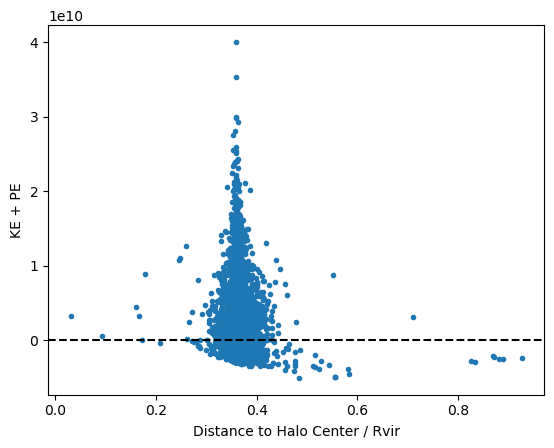

In [35]:
#sns.kdeplot(x = halo_star_r/(ray_halo_rvir*ds.units.code_length).to('m'), y = E_list, fill=True)
plt.plot(halo_star_r/(ray_halo_rvir*ds.units.code_length).to('m'), E_list, '.')
plt.axhline(0, linestyle='--', color='black')
plt.ylabel('KE + PE')
plt.xlabel('Distance to Halo Center / Rvir')

Only 30% of the stars are bound, which is unlikely. The error may come from the fact that the center of the stellar population is significantly off from the halo center, this introduces errors in the energy calculation. 

Suggestion from Kirk: subtract 

Use peak to determine the group of 

### Star Assignment Technique from AGORA Paper V and VII

Because SHINBAD output doesn't store the maximum circular velocity, we need to estimate it from the circular velocity at the virial radius

In [2]:
def weighted_std(values, weights_list):
    """
    Return the weighted standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights_list)
    N = len(values)
    # Fast and numerically precise:
    variance = np.sum(weights_list*(values-average)**2)/((N-1)*np.sum(weights_list)/N)
    return np.sqrt(variance)

In [3]:
def star_assignment(tree, branch, idx, pfs, sigma_cut = 2, distance_cut = 2):
    ds = yt.load(pfs[int(idx)])
    #
    branch = '0_4'
    halo_center = tree[branch][int(idx)]['Halo_Center']
    halo_rvir = tree[branch][int(idx)]['Halo_Radius']
    halo_mass = tree[branch][int(idx)]['Halo_Mass']
    halo_vel = tree[branch][int(idx)]['Vel_Com']
    halo_vel = (halo_vel*ds.units.code_length/ds.units.s).to('km/s').v
    #
    halo_rvir_si = ((halo_rvir*ds.units.code_length).to('m').v)*u.m
    halo_mass_si = ((halo_mass*ds.units.Msun).to('kg').v)*u.kg
    vcir = np.sqrt(G*halo_mass_si/halo_rvir_si).to('km/s').value #this is the circular velocity at r = Rvir
    #

In [17]:
idx = '194'
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()
ds = yt.load(ray_pfs[int(idx)])

yt : [INFO     ] 2024-12-11 16:59:32,587 Parameters: current_time              = 19.408071964245
yt : [INFO     ] 2024-12-11 16:59:32,590 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-11 16:59:32,592 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-11 16:59:32,595 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-11 16:59:32,597 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-11 16:59:32,600 Parameters: current_redshift          = 11.215615860209
yt : [INFO     ] 2024-12-11 16:59:32,602 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-11 16:59:32,604 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-11 16:59:32,607 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-11 16:59:32,607 Parameters: hubble_constant           = 0.679


In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()

In [18]:
branch = '0'
halo_center = ray_rawtree[branch][int(idx)]['Halo_Center']
halo_rvir = ray_rawtree[branch][int(idx)]['Halo_Radius']
halo_mass = ray_rawtree[branch][int(idx)]['Halo_Mass']
halo_vel = ray_rawtree[branch][int(idx)]['Vel_Com']
halo_vel = (halo_vel*ds.units.code_length/ds.units.s).to('km/s').v

halo_rvir_si = ((halo_rvir*ds.units.code_length).to('m').v)*u.m
halo_mass_si = ((halo_mass*ds.units.Msun).to('kg').v)*u.kg
vcir = np.sqrt(G*halo_mass_si/halo_rvir_si).to('km/s').value #this is the circular velocity at r = Rvir

In [19]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_mass_all = ray_metadata['mass']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [20]:
#Identify all the stars within the halo region
inreg_bool = np.linalg.norm(ray_pos_all - halo_center, axis=1) < halo_rvir
inreg_pos = ray_pos_all[inreg_bool]
inreg_r = np.linalg.norm(inreg_pos - halo_center, axis=1)
#
inreg_vel = ray_vel_all[inreg_bool]
inreg_relvel = inreg_vel - halo_vel
inreg_relvelmag = np.linalg.norm(inreg_relvel, axis=1)
#
inreg_ID = ray_ID_all[inreg_bool]
inreg_mass = ray_mass_all[inreg_bool]

In [21]:
sigma_cut = 2
distance_cut = 2

In [22]:
reduced_bool = np.logical_and(inreg_r < 0.8*halo_rvir, inreg_relvelmag < 4*vcir)
reduced_mass = inreg_mass[reduced_bool]
reduced_pos = inreg_pos[reduced_bool]
reduced_com = np.average(reduced_pos, weights=reduced_mass, axis=0)
#
reduced_vel = inreg_vel[reduced_bool]
reduced_relvel = reduced_vel - np.average(reduced_vel, weights=reduced_mass, axis=0)
reduced_relvelmag = np.linalg.norm(reduced_relvel, axis=1)
sigma_vel = weighted_std(reduced_relvelmag, weights_list=reduced_mass)
#
reduced_ID = inreg_ID[reduced_bool]

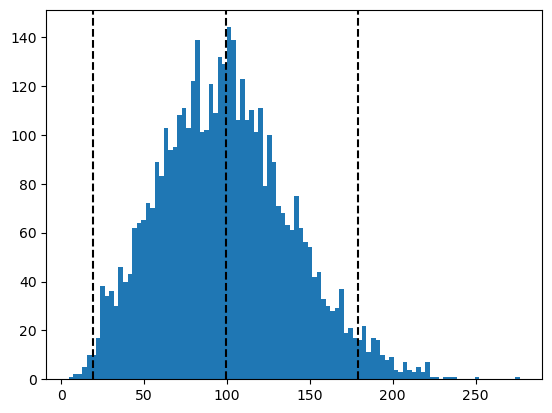

In [11]:
plt.hist(reduced_relvelmag, bins=100)
plt.axvline(np.average(reduced_relvelmag), color='k', linestyle='--')
plt.axvline(np.average(reduced_relvelmag) - sigma_cut*sigma_vel, color='k', linestyle='--')
plt.axvline(np.average(reduced_relvelmag) + sigma_cut*sigma_vel, color='k', linestyle='--')

In [23]:
def cal_R90(pos, center, mass):
    r = np.linalg.norm(pos - center, axis=1)
    r_sort = r[np.argsort(r)]
    mass_sort = mass[np.argsort(r)]
    mass_cumsum = np.cumsum(mass_sort)
    mass_cumsumpercent = mass_cumsum/mass_cumsum[-1]
    R90 = r_sort[np.where(mass_cumsumpercent > 0.9)[0][0]]
    return R90

In [24]:
r90_halocenter = cal_R90(reduced_pos, halo_center, reduced_mass)
r90_starcenter = cal_R90(reduced_pos, reduced_com, reduced_mass)

In [25]:
reduced2_bool = (np.linalg.norm(reduced_pos - halo_center, axis=1) < distance_cut*r90_halocenter) & \
                (np.linalg.norm(reduced_pos - reduced_com, axis=1) < distance_cut*r90_starcenter) & \
                (reduced_relvelmag <= np.average(reduced_relvelmag) + sigma_cut*sigma_vel)
reduced2_pos = reduced_pos[reduced2_bool]
reduced2_mass = reduced_mass[reduced2_bool]
reduced2_ID = reduced_ID[reduced2_bool]
reduced2_vel = reduced_vel[reduced2_bool]
reduced2_com = np.average(reduced2_pos, weights=reduced2_mass, axis=0)

In [26]:
counter = 0
while np.sum(reduced2_bool)/len(reduced2_bool) <= 0.99:
    if len(reduced2_pos) == 0:
        reduced2_com = np.nan
        break
    reduced2_relvel = reduced2_vel - np.average(reduced2_vel, weights=reduced2_mass, axis=0)
    reduced2_relvelmag = np.linalg.norm(reduced2_relvel, axis=1)
    #
    sigma_vel = weighted_std(reduced2_relvelmag, weights_list=reduced2_mass)
    r90_halocenter = cal_R90(reduced2_pos, halo_center, reduced2_mass)
    r90_starcenter = cal_R90(reduced2_pos, reduced2_com, reduced2_mass)
    #
    reduced2_bool = (np.linalg.norm(reduced2_pos - halo_center, axis=1) < distance_cut*r90_halocenter) & \
                    (np.linalg.norm(reduced2_pos - reduced2_com, axis=1) < distance_cut*r90_starcenter) & \
                    (reduced2_relvelmag <= np.average(reduced2_relvelmag) + sigma_cut*sigma_vel)
    reduced2_pos = reduced2_pos[reduced2_bool]
    reduced2_mass = reduced2_mass[reduced2_bool]
    reduced2_ID = reduced2_ID[reduced2_bool]
    reduced2_vel = reduced2_vel[reduced2_bool]
    reduced2_com = np.average(reduced2_pos, weights=reduced2_mass, axis=0)
    counter += 1
    print(counter)

1
2
3


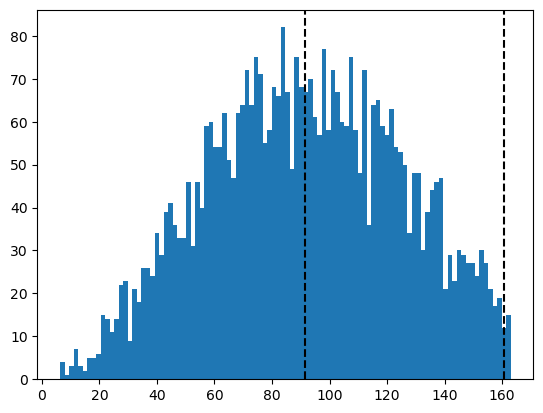

In [19]:
plt.hist(reduced2_relvelmag, bins=100)
plt.axvline(np.average(reduced2_relvelmag), color='k', linestyle='--')
plt.axvline(np.average(reduced2_relvelmag) + sigma_cut*sigma_vel, color='k', linestyle='--')

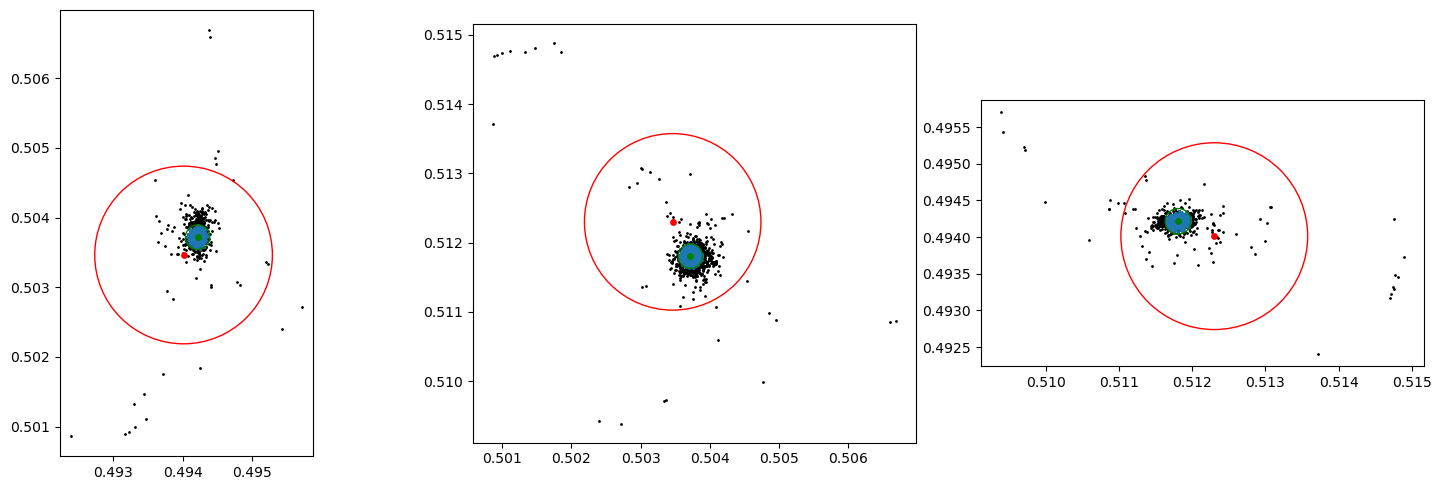

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

axs[0].scatter(inreg_pos[:,0], inreg_pos[:,1], s=1, color='black')

axs[0].scatter(reduced2_pos[:,0], reduced2_pos[:,1], s=1)

axs[0].scatter(halo_center[0], halo_center[1], color='red', s=15)
circle1 = plt.Circle((halo_center[0], halo_center[1]), distance_cut*r90_halocenter, color='red', fill=False)
axs[0].add_patch(circle1)

axs[0].scatter(reduced2_com[0], reduced2_com[1], color='green', s=15)
circle2 = plt.Circle((reduced2_com[0], reduced2_com[1]), distance_cut*r90_starcenter, color='green', fill=False)
axs[0].add_patch(circle2)

axs[0].set_aspect('equal')

#---------------------------------------------------------
axs[1].scatter(inreg_pos[:,1], inreg_pos[:,2], s=1, color='black')

axs[1].scatter(reduced2_pos[:,1], reduced2_pos[:,2], s=1)

axs[1].scatter(halo_center[1], halo_center[2], color='red', s=15)
circle1 = plt.Circle((halo_center[1], halo_center[2]), distance_cut*r90_halocenter, color='red', fill=False)
axs[1].add_patch(circle1)

axs[1].scatter(reduced2_com[1], reduced2_com[2], color='green', s=15)
circle2 = plt.Circle((reduced2_com[1], reduced2_com[2]), distance_cut*r90_starcenter, color='green', fill=False)
axs[1].add_patch(circle2)

axs[1].set_aspect('equal')
#---------------------------------------------------------
axs[2].scatter(inreg_pos[:,2], inreg_pos[:,0], s=1, color='black')

axs[2].scatter(reduced2_pos[:,2], reduced2_pos[:,0], s=1)

axs[2].scatter(halo_center[2], halo_center[0], color='red', s=15)
circle1 = plt.Circle((halo_center[2], halo_center[0]), distance_cut*r90_halocenter, color='red', fill=False)
axs[2].add_patch(circle1)

axs[2].scatter(reduced2_com[2], reduced2_com[0], color='green', s=15)
circle2 = plt.Circle((reduced2_com[2], reduced2_com[0]), distance_cut*r90_starcenter, color='green', fill=False)
axs[2].add_patch(circle2)

axs[2].set_aspect('equal')

fig.tight_layout()